In [2]:
#import all the required libraries
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from keras.models import Model
from keras import optimizers
from keras.layers import concatenate,AveragePooling2D
import os
print(os.listdir("E:/Users/NM/envs/cv/bloodcell/input"))
import cv2
import scipy
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


['dataset-master', 'dataset2-master']


In [3]:
#convert the string label of image into numerical form.
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL']:
                label = 1
                label2 = 1
            elif wbc_type in ['EOSINOPHIL']:
                label = 2
                label2 = 1
            elif wbc_type in ['MONOCYTE']:
                label = 3  
                label2 = 0
            elif wbc_type in ['LYMPHOCYTE']:
                label = 4 
                label2 = 0
            else:
                label = 5
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
#split the data into test and train
X_train, y_train, z_train = get_data('E:/Users/NM/envs/cv/bloodcell/input/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test, z_test = get_data('E:/Users/NM/envs/cv/bloodcell/input/dataset2-master/dataset2-master/images/TEST/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 5)
y_testHot = to_categorical(y_test, num_classes = 5)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

  0%|                                                                                         | 0/2497 [00:00<?, ?it/s]E:\Users\NM\envs\cv\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:02<00:00, 229.79it/s]


{1: 'NEUTROPHIL', 2: 'EOSINOPHIL', 3: 'MONOCYTE', 4: 'LYMPHOCYTE'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [4]:
print("Train X Shape --> ",X_train.shape)
print("Train y Shape --> ",y_trainHot.shape)
print("Train z Shape --> ",z_trainHot.shape)
##
# Input Layer (-1, 60, 80, 3) All three channel RGB
# Output Layer 1 (-1, 5) Softmax
# Output Layer 2 (-1, 2) Softmax (Doesn't work as 2nd output backpropogation messes all the weights)
##


Train X Shape -->  (9957, 60, 80, 3)
Train y Shape -->  (9957, 5)
Train z Shape -->  (9957, 2)


In [5]:
#writing the cnn architecture for classifying the images
def keras_model(block_num=2):
    inp = Input(shape=(60,80,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(2,2))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k)
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        #if j%2 == 0:
        #    x = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(x)
        #x = BatchNormalization(axis=-1)(x)
        k = x
   # x = Dropout(0.5)(k)
    x = MaxPool2D(pool_size=(7, 7), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    #x = Dense(1024,activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    y = Dense(5,activation="softmax")(x)
#    z = Dense(2,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model
model = keras_model(4)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 80, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 40, 32)   4736        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 15, 20, 32)   0           conv2d_1[0][0]                   
_____________________________________

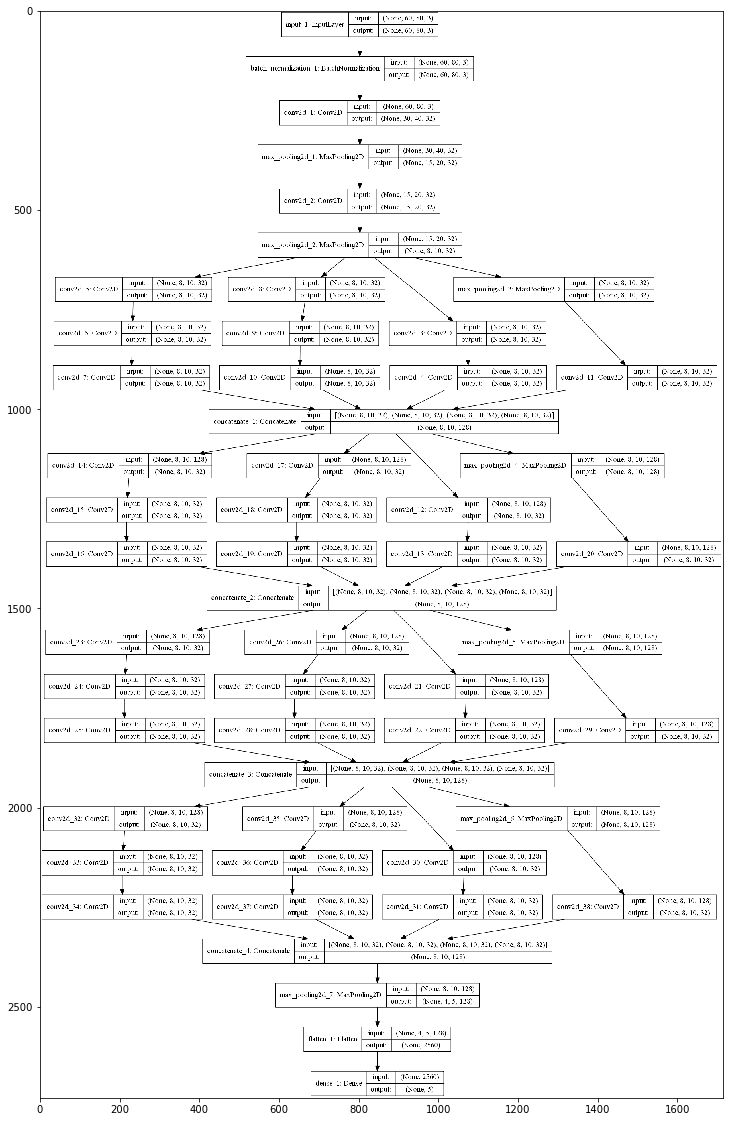

In [6]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(16,20))
plt.imshow(plt.imread('model_plot.png'))


In [7]:
#get the weight file for feeding to neural network
filepath = "E:/Users/NM/envs/cv/bloodcell/weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_trainHot,
         epochs = 40,
         batch_size = 32,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)

Instructions for updating:
Use tf.cast instead.
Train on 9957 samples, validate on 2487 samples
Epoch 1/40


6528/9957 [==================>...........] - ETA: 27:12 - loss: 1.6423 - acc: 0.15 - ETA: 15:03 - loss: 1.5568 - acc: 0.23 - ETA: 11:00 - loss: 1.5035 - acc: 0.26 - ETA: 8:59 - loss: 1.4952 - acc: 0.2578 - ETA: 7:45 - loss: 1.5634 - acc: 0.231 - ETA: 6:56 - loss: 1.5304 - acc: 0.229 - ETA: 6:20 - loss: 1.5131 - acc: 0.232 - ETA: 5:52 - loss: 1.5048 - acc: 0.226 - ETA: 5:31 - loss: 1.5032 - acc: 0.225 - ETA: 5:14 - loss: 1.4905 - acc: 0.234 - ETA: 5:01 - loss: 1.4897 - acc: 0.227 - ETA: 4:49 - loss: 1.4815 - acc: 0.239 - ETA: 4:39 - loss: 1.4780 - acc: 0.233 - ETA: 4:31 - loss: 1.4769 - acc: 0.223 - ETA: 4:23 - loss: 1.4723 - acc: 0.225 - ETA: 4:16 - loss: 1.4679 - acc: 0.226 - ETA: 4:11 - loss: 1.4625 - acc: 0.227 - ETA: 4:05 - loss: 1.4611 - acc: 0.230 - ETA: 4:00 - loss: 1.4604 - acc: 0.227 - ETA: 3:57 - loss: 1.4556 - acc: 0.232 - ETA: 3:52 - loss: 1.4493 - acc: 0.239 - ETA: 3:49 - loss: 1.4532 - acc: 0.238 - ETA: 3:45 - loss: 1.4552 - acc: 0.237 - ETA: 3:42 - loss: 1.4550 - acc: 0.

6528/9957 [==================>...........] - ETA: 3:06 - loss: 0.4935 - acc: 0.781 - ETA: 3:04 - loss: 0.6364 - acc: 0.703 - ETA: 3:00 - loss: 0.6742 - acc: 0.677 - ETA: 2:57 - loss: 0.7014 - acc: 0.687 - ETA: 2:56 - loss: 0.7193 - acc: 0.675 - ETA: 2:55 - loss: 0.7454 - acc: 0.661 - ETA: 2:55 - loss: 0.7213 - acc: 0.674 - ETA: 2:54 - loss: 0.7194 - acc: 0.660 - ETA: 2:54 - loss: 0.7154 - acc: 0.670 - ETA: 2:53 - loss: 0.7045 - acc: 0.678 - ETA: 2:53 - loss: 0.7115 - acc: 0.681 - ETA: 2:52 - loss: 0.7077 - acc: 0.682 - ETA: 2:52 - loss: 0.7062 - acc: 0.680 - ETA: 2:51 - loss: 0.7164 - acc: 0.671 - ETA: 2:50 - loss: 0.7077 - acc: 0.681 - ETA: 2:49 - loss: 0.7084 - acc: 0.681 - ETA: 2:49 - loss: 0.7002 - acc: 0.685 - ETA: 2:48 - loss: 0.6955 - acc: 0.691 - ETA: 2:49 - loss: 0.6970 - acc: 0.685 - ETA: 2:48 - loss: 0.6920 - acc: 0.685 - ETA: 2:47 - loss: 0.6771 - acc: 0.692 - ETA: 2:47 - loss: 0.6746 - acc: 0.688 - ETA: 2:46 - loss: 0.6720 - acc: 0.691 - ETA: 2:46 - loss: 0.6755 - acc: 0.6

9957/9957 [==============================] - ETA: 1:01 - loss: 0.5880 - acc: 0.740 - ETA: 1:00 - loss: 0.5869 - acc: 0.740 - ETA: 1:00 - loss: 0.5856 - acc: 0.741 - ETA: 59s - loss: 0.5848 - acc: 0.742 - ETA: 59s - loss: 0.5837 - acc: 0.74 - ETA: 58s - loss: 0.5818 - acc: 0.74 - ETA: 57s - loss: 0.5804 - acc: 0.74 - ETA: 57s - loss: 0.5786 - acc: 0.74 - ETA: 56s - loss: 0.5793 - acc: 0.74 - ETA: 56s - loss: 0.5786 - acc: 0.74 - ETA: 55s - loss: 0.5769 - acc: 0.74 - ETA: 55s - loss: 0.5753 - acc: 0.74 - ETA: 54s - loss: 0.5748 - acc: 0.74 - ETA: 54s - loss: 0.5738 - acc: 0.74 - ETA: 53s - loss: 0.5752 - acc: 0.74 - ETA: 52s - loss: 0.5750 - acc: 0.74 - ETA: 52s - loss: 0.5740 - acc: 0.74 - ETA: 51s - loss: 0.5730 - acc: 0.74 - ETA: 51s - loss: 0.5725 - acc: 0.74 - ETA: 50s - loss: 0.5719 - acc: 0.74 - ETA: 50s - loss: 0.5719 - acc: 0.74 - ETA: 49s - loss: 0.5717 - acc: 0.74 - ETA: 48s - loss: 0.5713 - acc: 0.74 - ETA: 48s - loss: 0.5709 - acc: 0.74 - ETA: 47s - loss: 0.5705 - acc: 0.74 

6528/9957 [==================>...........] - ETA: 3:00 - loss: 0.6536 - acc: 0.781 - ETA: 3:01 - loss: 0.4854 - acc: 0.859 - ETA: 3:01 - loss: 0.5631 - acc: 0.791 - ETA: 3:00 - loss: 0.5832 - acc: 0.781 - ETA: 3:00 - loss: 0.5402 - acc: 0.793 - ETA: 2:59 - loss: 0.4924 - acc: 0.817 - ETA: 2:57 - loss: 0.4681 - acc: 0.825 - ETA: 2:56 - loss: 0.4736 - acc: 0.824 - ETA: 2:55 - loss: 0.4911 - acc: 0.809 - ETA: 2:54 - loss: 0.5040 - acc: 0.793 - ETA: 2:54 - loss: 0.5169 - acc: 0.784 - ETA: 2:53 - loss: 0.5107 - acc: 0.781 - ETA: 2:52 - loss: 0.5004 - acc: 0.783 - ETA: 2:52 - loss: 0.4775 - acc: 0.792 - ETA: 2:51 - loss: 0.4763 - acc: 0.791 - ETA: 2:50 - loss: 0.4566 - acc: 0.800 - ETA: 2:50 - loss: 0.4536 - acc: 0.803 - ETA: 2:49 - loss: 0.4492 - acc: 0.807 - ETA: 2:49 - loss: 0.4396 - acc: 0.810 - ETA: 2:49 - loss: 0.4337 - acc: 0.815 - ETA: 2:48 - loss: 0.4245 - acc: 0.818 - ETA: 2:48 - loss: 0.4216 - acc: 0.819 - ETA: 2:47 - loss: 0.4149 - acc: 0.822 - ETA: 2:46 - loss: 0.4138 - acc: 0.8

6528/9957 [==================>...........] - ETA: 3:12 - loss: 0.3942 - acc: 0.843 - ETA: 3:02 - loss: 0.3269 - acc: 0.890 - ETA: 3:01 - loss: 0.2987 - acc: 0.885 - ETA: 2:59 - loss: 0.2814 - acc: 0.882 - ETA: 2:57 - loss: 0.2926 - acc: 0.875 - ETA: 2:55 - loss: 0.2802 - acc: 0.885 - ETA: 2:54 - loss: 0.2727 - acc: 0.879 - ETA: 2:53 - loss: 0.2898 - acc: 0.871 - ETA: 2:52 - loss: 0.3056 - acc: 0.850 - ETA: 2:52 - loss: 0.2949 - acc: 0.856 - ETA: 2:51 - loss: 0.2809 - acc: 0.863 - ETA: 2:51 - loss: 0.2711 - acc: 0.869 - ETA: 2:50 - loss: 0.2638 - acc: 0.875 - ETA: 2:49 - loss: 0.2586 - acc: 0.877 - ETA: 2:49 - loss: 0.2586 - acc: 0.879 - ETA: 2:48 - loss: 0.2578 - acc: 0.880 - ETA: 2:47 - loss: 0.2522 - acc: 0.884 - ETA: 2:47 - loss: 0.2539 - acc: 0.885 - ETA: 2:48 - loss: 0.2474 - acc: 0.888 - ETA: 2:48 - loss: 0.2475 - acc: 0.890 - ETA: 2:47 - loss: 0.2494 - acc: 0.891 - ETA: 2:46 - loss: 0.2514 - acc: 0.890 - ETA: 2:46 - loss: 0.2500 - acc: 0.892 - ETA: 2:45 - loss: 0.2463 - acc: 0.8

9957/9957 [==============================] - ETA: 1:00 - loss: 0.2179 - acc: 0.903 - ETA: 1:00 - loss: 0.2173 - acc: 0.903 - ETA: 59s - loss: 0.2171 - acc: 0.903 - ETA: 59s - loss: 0.2175 - acc: 0.90 - ETA: 58s - loss: 0.2181 - acc: 0.90 - ETA: 58s - loss: 0.2205 - acc: 0.90 - ETA: 57s - loss: 0.2216 - acc: 0.90 - ETA: 56s - loss: 0.2223 - acc: 0.90 - ETA: 56s - loss: 0.2222 - acc: 0.90 - ETA: 55s - loss: 0.2221 - acc: 0.90 - ETA: 55s - loss: 0.2231 - acc: 0.90 - ETA: 54s - loss: 0.2246 - acc: 0.90 - ETA: 54s - loss: 0.2250 - acc: 0.90 - ETA: 53s - loss: 0.2261 - acc: 0.89 - ETA: 52s - loss: 0.2265 - acc: 0.89 - ETA: 52s - loss: 0.2263 - acc: 0.89 - ETA: 51s - loss: 0.2267 - acc: 0.89 - ETA: 51s - loss: 0.2276 - acc: 0.89 - ETA: 50s - loss: 0.2277 - acc: 0.89 - ETA: 50s - loss: 0.2280 - acc: 0.89 - ETA: 49s - loss: 0.2297 - acc: 0.89 - ETA: 48s - loss: 0.2293 - acc: 0.89 - ETA: 48s - loss: 0.2293 - acc: 0.89 - ETA: 47s - loss: 0.2292 - acc: 0.89 - ETA: 47s - loss: 0.2290 - acc: 0.89 - 

6528/9957 [==================>...........] - ETA: 2:52 - loss: 0.1938 - acc: 0.906 - ETA: 2:55 - loss: 0.1429 - acc: 0.921 - ETA: 2:55 - loss: 0.1648 - acc: 0.895 - ETA: 2:55 - loss: 0.2386 - acc: 0.890 - ETA: 2:54 - loss: 0.2186 - acc: 0.900 - ETA: 2:54 - loss: 0.2249 - acc: 0.890 - ETA: 2:53 - loss: 0.2104 - acc: 0.897 - ETA: 2:52 - loss: 0.2123 - acc: 0.898 - ETA: 2:52 - loss: 0.2199 - acc: 0.899 - ETA: 2:51 - loss: 0.2159 - acc: 0.906 - ETA: 2:54 - loss: 0.2097 - acc: 0.906 - ETA: 2:53 - loss: 0.2025 - acc: 0.911 - ETA: 2:53 - loss: 0.1964 - acc: 0.913 - ETA: 2:52 - loss: 0.1957 - acc: 0.915 - ETA: 2:51 - loss: 0.1925 - acc: 0.916 - ETA: 2:51 - loss: 0.1839 - acc: 0.919 - ETA: 2:50 - loss: 0.1865 - acc: 0.921 - ETA: 2:49 - loss: 0.1923 - acc: 0.921 - ETA: 2:48 - loss: 0.1925 - acc: 0.922 - ETA: 2:48 - loss: 0.1961 - acc: 0.921 - ETA: 2:47 - loss: 0.1963 - acc: 0.919 - ETA: 2:46 - loss: 0.2070 - acc: 0.917 - ETA: 2:46 - loss: 0.2100 - acc: 0.915 - ETA: 2:45 - loss: 0.2136 - acc: 0.9

6528/9957 [==================>...........] - ETA: 2:59 - loss: 0.1624 - acc: 0.937 - ETA: 3:00 - loss: 0.1379 - acc: 0.937 - ETA: 3:00 - loss: 0.1402 - acc: 0.937 - ETA: 3:00 - loss: 0.1372 - acc: 0.953 - ETA: 2:59 - loss: 0.1433 - acc: 0.937 - ETA: 3:03 - loss: 0.1345 - acc: 0.942 - ETA: 3:02 - loss: 0.1408 - acc: 0.942 - ETA: 3:00 - loss: 0.1465 - acc: 0.941 - ETA: 2:59 - loss: 0.1614 - acc: 0.930 - ETA: 2:58 - loss: 0.1560 - acc: 0.931 - ETA: 2:58 - loss: 0.1655 - acc: 0.923 - ETA: 2:57 - loss: 0.1577 - acc: 0.929 - ETA: 2:56 - loss: 0.1530 - acc: 0.935 - ETA: 2:56 - loss: 0.1533 - acc: 0.935 - ETA: 2:55 - loss: 0.1496 - acc: 0.937 - ETA: 2:54 - loss: 0.1483 - acc: 0.937 - ETA: 2:53 - loss: 0.1476 - acc: 0.939 - ETA: 2:52 - loss: 0.1641 - acc: 0.930 - ETA: 2:51 - loss: 0.1629 - acc: 0.930 - ETA: 2:51 - loss: 0.1565 - acc: 0.934 - ETA: 2:51 - loss: 0.1521 - acc: 0.936 - ETA: 2:50 - loss: 0.1525 - acc: 0.936 - ETA: 2:49 - loss: 0.1545 - acc: 0.934 - ETA: 2:49 - loss: 0.1522 - acc: 0.9

9957/9957 [==============================] - ETA: 1:04 - loss: 0.1489 - acc: 0.939 - ETA: 1:03 - loss: 0.1489 - acc: 0.939 - ETA: 1:03 - loss: 0.1484 - acc: 0.939 - ETA: 1:02 - loss: 0.1480 - acc: 0.940 - ETA: 1:02 - loss: 0.1477 - acc: 0.940 - ETA: 1:01 - loss: 0.1475 - acc: 0.940 - ETA: 1:00 - loss: 0.1471 - acc: 0.940 - ETA: 1:00 - loss: 0.1471 - acc: 0.940 - ETA: 59s - loss: 0.1468 - acc: 0.940 - ETA: 59s - loss: 0.1471 - acc: 0.94 - ETA: 58s - loss: 0.1468 - acc: 0.94 - ETA: 57s - loss: 0.1469 - acc: 0.94 - ETA: 57s - loss: 0.1466 - acc: 0.94 - ETA: 56s - loss: 0.1469 - acc: 0.94 - ETA: 56s - loss: 0.1465 - acc: 0.94 - ETA: 55s - loss: 0.1464 - acc: 0.94 - ETA: 54s - loss: 0.1478 - acc: 0.94 - ETA: 54s - loss: 0.1479 - acc: 0.94 - ETA: 53s - loss: 0.1482 - acc: 0.94 - ETA: 53s - loss: 0.1486 - acc: 0.94 - ETA: 52s - loss: 0.1484 - acc: 0.94 - ETA: 51s - loss: 0.1480 - acc: 0.94 - ETA: 51s - loss: 0.1481 - acc: 0.94 - ETA: 50s - loss: 0.1477 - acc: 0.94 - ETA: 49s - loss: 0.1472 - 

6528/9957 [==================>...........] - ETA: 2:59 - loss: 0.0478 - acc: 1.000 - ETA: 3:01 - loss: 0.1477 - acc: 0.968 - ETA: 3:02 - loss: 0.1439 - acc: 0.968 - ETA: 3:02 - loss: 0.1879 - acc: 0.937 - ETA: 3:03 - loss: 0.1734 - acc: 0.943 - ETA: 3:03 - loss: 0.1738 - acc: 0.942 - ETA: 3:02 - loss: 0.1669 - acc: 0.942 - ETA: 3:01 - loss: 0.1646 - acc: 0.941 - ETA: 3:01 - loss: 0.1476 - acc: 0.947 - ETA: 3:01 - loss: 0.1459 - acc: 0.946 - ETA: 3:01 - loss: 0.1442 - acc: 0.946 - ETA: 3:00 - loss: 0.1697 - acc: 0.945 - ETA: 3:01 - loss: 0.1717 - acc: 0.944 - ETA: 3:00 - loss: 0.1724 - acc: 0.942 - ETA: 3:00 - loss: 0.1813 - acc: 0.939 - ETA: 2:59 - loss: 0.1712 - acc: 0.943 - ETA: 2:58 - loss: 0.1814 - acc: 0.939 - ETA: 2:58 - loss: 0.1801 - acc: 0.939 - ETA: 2:57 - loss: 0.1739 - acc: 0.939 - ETA: 2:57 - loss: 0.1729 - acc: 0.937 - ETA: 2:56 - loss: 0.1819 - acc: 0.936 - ETA: 2:56 - loss: 0.1898 - acc: 0.930 - ETA: 2:55 - loss: 0.1832 - acc: 0.933 - ETA: 2:55 - loss: 0.1792 - acc: 0.9

6528/9957 [==================>...........] - ETA: 3:21 - loss: 0.0423 - acc: 1.000 - ETA: 3:16 - loss: 0.0709 - acc: 0.984 - ETA: 3:21 - loss: 0.1079 - acc: 0.968 - ETA: 3:16 - loss: 0.1028 - acc: 0.976 - ETA: 3:14 - loss: 0.1063 - acc: 0.975 - ETA: 3:11 - loss: 0.0963 - acc: 0.979 - ETA: 3:09 - loss: 0.1108 - acc: 0.964 - ETA: 3:07 - loss: 0.1175 - acc: 0.960 - ETA: 3:06 - loss: 0.1075 - acc: 0.965 - ETA: 3:04 - loss: 0.0984 - acc: 0.968 - ETA: 3:03 - loss: 0.0968 - acc: 0.968 - ETA: 3:02 - loss: 0.0911 - acc: 0.971 - ETA: 3:01 - loss: 0.0905 - acc: 0.968 - ETA: 3:00 - loss: 0.0935 - acc: 0.968 - ETA: 2:59 - loss: 0.0993 - acc: 0.968 - ETA: 2:58 - loss: 0.0990 - acc: 0.968 - ETA: 2:56 - loss: 0.1002 - acc: 0.968 - ETA: 2:55 - loss: 0.0964 - acc: 0.970 - ETA: 2:54 - loss: 0.1002 - acc: 0.967 - ETA: 2:54 - loss: 0.0976 - acc: 0.967 - ETA: 2:54 - loss: 0.0974 - acc: 0.967 - ETA: 2:54 - loss: 0.0964 - acc: 0.967 - ETA: 2:54 - loss: 0.0956 - acc: 0.967 - ETA: 2:54 - loss: 0.0929 - acc: 0.9

9957/9957 [==============================] - ETA: 1:02 - loss: 0.1197 - acc: 0.953 - ETA: 1:02 - loss: 0.1192 - acc: 0.953 - ETA: 1:01 - loss: 0.1188 - acc: 0.953 - ETA: 1:00 - loss: 0.1184 - acc: 0.953 - ETA: 1:00 - loss: 0.1184 - acc: 0.953 - ETA: 59s - loss: 0.1183 - acc: 0.953 - ETA: 59s - loss: 0.1185 - acc: 0.95 - ETA: 58s - loss: 0.1181 - acc: 0.95 - ETA: 57s - loss: 0.1176 - acc: 0.95 - ETA: 57s - loss: 0.1173 - acc: 0.95 - ETA: 56s - loss: 0.1170 - acc: 0.95 - ETA: 56s - loss: 0.1166 - acc: 0.95 - ETA: 55s - loss: 0.1162 - acc: 0.95 - ETA: 54s - loss: 0.1160 - acc: 0.95 - ETA: 54s - loss: 0.1156 - acc: 0.95 - ETA: 53s - loss: 0.1153 - acc: 0.95 - ETA: 53s - loss: 0.1150 - acc: 0.95 - ETA: 52s - loss: 0.1148 - acc: 0.95 - ETA: 51s - loss: 0.1145 - acc: 0.95 - ETA: 51s - loss: 0.1141 - acc: 0.95 - ETA: 50s - loss: 0.1139 - acc: 0.95 - ETA: 50s - loss: 0.1141 - acc: 0.95 - ETA: 49s - loss: 0.1137 - acc: 0.95 - ETA: 49s - loss: 0.1133 - acc: 0.95 - ETA: 48s - loss: 0.1129 - acc: 0

6528/9957 [==================>...........] - ETA: 2:51 - loss: 0.0092 - acc: 1.000 - ETA: 2:53 - loss: 0.0316 - acc: 0.984 - ETA: 2:53 - loss: 0.0394 - acc: 0.979 - ETA: 2:54 - loss: 0.0325 - acc: 0.984 - ETA: 2:53 - loss: 0.0523 - acc: 0.981 - ETA: 2:52 - loss: 0.0577 - acc: 0.974 - ETA: 2:53 - loss: 0.0513 - acc: 0.977 - ETA: 2:52 - loss: 0.0497 - acc: 0.980 - ETA: 2:51 - loss: 0.0574 - acc: 0.979 - ETA: 2:51 - loss: 0.0559 - acc: 0.981 - ETA: 2:50 - loss: 0.0581 - acc: 0.980 - ETA: 2:50 - loss: 0.0556 - acc: 0.981 - ETA: 2:49 - loss: 0.0538 - acc: 0.983 - ETA: 2:49 - loss: 0.0538 - acc: 0.984 - ETA: 2:48 - loss: 0.0623 - acc: 0.979 - ETA: 2:48 - loss: 0.0597 - acc: 0.980 - ETA: 2:47 - loss: 0.0574 - acc: 0.981 - ETA: 2:47 - loss: 0.0545 - acc: 0.982 - ETA: 2:46 - loss: 0.0531 - acc: 0.983 - ETA: 2:45 - loss: 0.0542 - acc: 0.982 - ETA: 2:45 - loss: 0.0553 - acc: 0.982 - ETA: 2:44 - loss: 0.0548 - acc: 0.983 - ETA: 2:43 - loss: 0.0553 - acc: 0.982 - ETA: 2:43 - loss: 0.0563 - acc: 0.9

6528/9957 [==================>...........] - ETA: 2:50 - loss: 0.0389 - acc: 0.968 - ETA: 2:53 - loss: 0.0385 - acc: 0.984 - ETA: 2:52 - loss: 0.0359 - acc: 0.989 - ETA: 2:52 - loss: 0.0394 - acc: 0.984 - ETA: 2:53 - loss: 0.0717 - acc: 0.975 - ETA: 2:51 - loss: 0.0622 - acc: 0.979 - ETA: 2:51 - loss: 0.0848 - acc: 0.964 - ETA: 2:49 - loss: 0.0787 - acc: 0.968 - ETA: 2:49 - loss: 0.0718 - acc: 0.972 - ETA: 2:48 - loss: 0.0849 - acc: 0.968 - ETA: 2:48 - loss: 0.0784 - acc: 0.971 - ETA: 2:47 - loss: 0.0796 - acc: 0.971 - ETA: 2:47 - loss: 0.0740 - acc: 0.973 - ETA: 2:46 - loss: 0.0695 - acc: 0.975 - ETA: 2:46 - loss: 0.0667 - acc: 0.977 - ETA: 2:47 - loss: 0.0629 - acc: 0.978 - ETA: 2:46 - loss: 0.0631 - acc: 0.977 - ETA: 2:46 - loss: 0.0670 - acc: 0.974 - ETA: 2:45 - loss: 0.0651 - acc: 0.975 - ETA: 2:45 - loss: 0.0694 - acc: 0.973 - ETA: 2:44 - loss: 0.0667 - acc: 0.974 - ETA: 2:43 - loss: 0.0645 - acc: 0.975 - ETA: 2:43 - loss: 0.0680 - acc: 0.974 - ETA: 2:42 - loss: 0.0676 - acc: 0.9

9957/9957 [==============================] - ETA: 1:00 - loss: 0.0670 - acc: 0.975 - ETA: 59s - loss: 0.0668 - acc: 0.975 - ETA: 59s - loss: 0.0675 - acc: 0.97 - ETA: 58s - loss: 0.0674 - acc: 0.97 - ETA: 58s - loss: 0.0676 - acc: 0.97 - ETA: 57s - loss: 0.0675 - acc: 0.97 - ETA: 56s - loss: 0.0672 - acc: 0.97 - ETA: 56s - loss: 0.0669 - acc: 0.97 - ETA: 55s - loss: 0.0666 - acc: 0.97 - ETA: 55s - loss: 0.0664 - acc: 0.97 - ETA: 54s - loss: 0.0661 - acc: 0.97 - ETA: 54s - loss: 0.0663 - acc: 0.97 - ETA: 53s - loss: 0.0661 - acc: 0.97 - ETA: 52s - loss: 0.0660 - acc: 0.97 - ETA: 52s - loss: 0.0658 - acc: 0.97 - ETA: 51s - loss: 0.0655 - acc: 0.97 - ETA: 51s - loss: 0.0655 - acc: 0.97 - ETA: 50s - loss: 0.0653 - acc: 0.97 - ETA: 50s - loss: 0.0650 - acc: 0.97 - ETA: 49s - loss: 0.0650 - acc: 0.97 - ETA: 49s - loss: 0.0649 - acc: 0.97 - ETA: 48s - loss: 0.0647 - acc: 0.97 - ETA: 47s - loss: 0.0645 - acc: 0.97 - ETA: 47s - loss: 0.0647 - acc: 0.97 - ETA: 46s - loss: 0.0646 - acc: 0.97 - ET

6528/9957 [==================>...........] - ETA: 2:53 - loss: 0.0112 - acc: 1.000 - ETA: 2:52 - loss: 0.0365 - acc: 0.984 - ETA: 2:51 - loss: 0.0367 - acc: 0.979 - ETA: 2:49 - loss: 0.0412 - acc: 0.976 - ETA: 2:49 - loss: 0.0392 - acc: 0.981 - ETA: 2:49 - loss: 0.0357 - acc: 0.984 - ETA: 2:48 - loss: 0.0351 - acc: 0.982 - ETA: 2:48 - loss: 0.0318 - acc: 0.984 - ETA: 2:47 - loss: 0.0288 - acc: 0.986 - ETA: 2:49 - loss: 0.0285 - acc: 0.987 - ETA: 2:47 - loss: 0.0266 - acc: 0.988 - ETA: 2:47 - loss: 0.0254 - acc: 0.989 - ETA: 2:46 - loss: 0.0265 - acc: 0.988 - ETA: 2:45 - loss: 0.0252 - acc: 0.988 - ETA: 2:45 - loss: 0.0300 - acc: 0.987 - ETA: 2:44 - loss: 0.0286 - acc: 0.988 - ETA: 2:44 - loss: 0.0272 - acc: 0.989 - ETA: 2:43 - loss: 0.0290 - acc: 0.987 - ETA: 2:42 - loss: 0.0279 - acc: 0.988 - ETA: 2:42 - loss: 0.0311 - acc: 0.987 - ETA: 2:41 - loss: 0.0298 - acc: 0.988 - ETA: 2:41 - loss: 0.0293 - acc: 0.988 - ETA: 2:40 - loss: 0.0288 - acc: 0.989 - ETA: 2:40 - loss: 0.0279 - acc: 0.9

6528/9957 [==================>...........] - ETA: 2:52 - loss: 0.0061 - acc: 1.000 - ETA: 2:52 - loss: 0.0063 - acc: 1.000 - ETA: 2:54 - loss: 0.0078 - acc: 1.000 - ETA: 2:54 - loss: 0.0222 - acc: 0.992 - ETA: 2:52 - loss: 0.0185 - acc: 0.993 - ETA: 2:51 - loss: 0.0155 - acc: 0.994 - ETA: 2:52 - loss: 0.0204 - acc: 0.991 - ETA: 2:52 - loss: 0.0247 - acc: 0.988 - ETA: 2:51 - loss: 0.0223 - acc: 0.989 - ETA: 2:52 - loss: 0.0228 - acc: 0.987 - ETA: 2:51 - loss: 0.0246 - acc: 0.985 - ETA: 2:50 - loss: 0.0373 - acc: 0.981 - ETA: 2:50 - loss: 0.0385 - acc: 0.980 - ETA: 2:49 - loss: 0.0366 - acc: 0.982 - ETA: 2:49 - loss: 0.0365 - acc: 0.981 - ETA: 2:48 - loss: 0.0408 - acc: 0.980 - ETA: 2:47 - loss: 0.0427 - acc: 0.979 - ETA: 2:47 - loss: 0.0406 - acc: 0.980 - ETA: 2:46 - loss: 0.0423 - acc: 0.980 - ETA: 2:46 - loss: 0.0412 - acc: 0.981 - ETA: 2:45 - loss: 0.0397 - acc: 0.982 - ETA: 2:45 - loss: 0.0380 - acc: 0.983 - ETA: 2:44 - loss: 0.0365 - acc: 0.983 - ETA: 2:43 - loss: 0.0353 - acc: 0.9

9957/9957 [==============================] - ETA: 1:00 - loss: 0.0839 - acc: 0.969 - ETA: 1:00 - loss: 0.0837 - acc: 0.970 - ETA: 59s - loss: 0.0835 - acc: 0.970 - ETA: 59s - loss: 0.0831 - acc: 0.97 - ETA: 58s - loss: 0.0830 - acc: 0.97 - ETA: 58s - loss: 0.0829 - acc: 0.97 - ETA: 57s - loss: 0.0830 - acc: 0.96 - ETA: 56s - loss: 0.0831 - acc: 0.96 - ETA: 56s - loss: 0.0828 - acc: 0.96 - ETA: 55s - loss: 0.0825 - acc: 0.97 - ETA: 55s - loss: 0.0824 - acc: 0.97 - ETA: 54s - loss: 0.0825 - acc: 0.97 - ETA: 54s - loss: 0.0823 - acc: 0.97 - ETA: 53s - loss: 0.0823 - acc: 0.97 - ETA: 52s - loss: 0.0820 - acc: 0.97 - ETA: 52s - loss: 0.0819 - acc: 0.97 - ETA: 51s - loss: 0.0819 - acc: 0.97 - ETA: 51s - loss: 0.0815 - acc: 0.97 - ETA: 50s - loss: 0.0813 - acc: 0.97 - ETA: 50s - loss: 0.0816 - acc: 0.97 - ETA: 49s - loss: 0.0815 - acc: 0.97 - ETA: 48s - loss: 0.0813 - acc: 0.97 - ETA: 48s - loss: 0.0815 - acc: 0.97 - ETA: 47s - loss: 0.0814 - acc: 0.97 - ETA: 47s - loss: 0.0818 - acc: 0.97 - 

6528/9957 [==================>...........] - ETA: 2:51 - loss: 0.0382 - acc: 0.968 - ETA: 2:55 - loss: 0.1479 - acc: 0.937 - ETA: 2:54 - loss: 0.1841 - acc: 0.916 - ETA: 2:59 - loss: 0.2140 - acc: 0.898 - ETA: 2:56 - loss: 0.1827 - acc: 0.918 - ETA: 2:56 - loss: 0.1830 - acc: 0.921 - ETA: 2:55 - loss: 0.1608 - acc: 0.933 - ETA: 2:52 - loss: 0.1511 - acc: 0.937 - ETA: 2:52 - loss: 0.1669 - acc: 0.934 - ETA: 2:52 - loss: 0.1523 - acc: 0.940 - ETA: 2:52 - loss: 0.1626 - acc: 0.937 - ETA: 2:51 - loss: 0.2049 - acc: 0.929 - ETA: 2:50 - loss: 0.1917 - acc: 0.935 - ETA: 2:49 - loss: 0.1871 - acc: 0.937 - ETA: 2:48 - loss: 0.1806 - acc: 0.939 - ETA: 2:47 - loss: 0.1861 - acc: 0.937 - ETA: 2:46 - loss: 0.1780 - acc: 0.941 - ETA: 2:46 - loss: 0.1733 - acc: 0.941 - ETA: 2:45 - loss: 0.1684 - acc: 0.942 - ETA: 2:45 - loss: 0.1648 - acc: 0.942 - ETA: 2:44 - loss: 0.1634 - acc: 0.942 - ETA: 2:44 - loss: 0.1576 - acc: 0.944 - ETA: 2:44 - loss: 0.1538 - acc: 0.947 - ETA: 2:43 - loss: 0.1592 - acc: 0.9

6528/9957 [==================>...........] - ETA: 3:09 - loss: 0.0179 - acc: 1.000 - ETA: 3:10 - loss: 0.0208 - acc: 1.000 - ETA: 3:10 - loss: 0.0533 - acc: 0.979 - ETA: 3:09 - loss: 0.0528 - acc: 0.984 - ETA: 3:08 - loss: 0.0479 - acc: 0.981 - ETA: 3:08 - loss: 0.0421 - acc: 0.984 - ETA: 3:07 - loss: 0.0371 - acc: 0.986 - ETA: 3:06 - loss: 0.0333 - acc: 0.988 - ETA: 3:05 - loss: 0.0305 - acc: 0.989 - ETA: 3:04 - loss: 0.0332 - acc: 0.987 - ETA: 3:04 - loss: 0.0365 - acc: 0.985 - ETA: 3:03 - loss: 0.0342 - acc: 0.987 - ETA: 3:03 - loss: 0.0377 - acc: 0.985 - ETA: 3:03 - loss: 0.0372 - acc: 0.986 - ETA: 3:04 - loss: 0.0350 - acc: 0.987 - ETA: 3:04 - loss: 0.0375 - acc: 0.986 - ETA: 3:04 - loss: 0.0355 - acc: 0.987 - ETA: 3:04 - loss: 0.0350 - acc: 0.987 - ETA: 3:04 - loss: 0.0337 - acc: 0.988 - ETA: 3:03 - loss: 0.0329 - acc: 0.989 - ETA: 3:03 - loss: 0.0337 - acc: 0.988 - ETA: 3:02 - loss: 0.0345 - acc: 0.987 - ETA: 3:02 - loss: 0.0334 - acc: 0.987 - ETA: 3:01 - loss: 0.0326 - acc: 0.9

9957/9957 [==============================] - ETA: 1:05 - loss: 0.0322 - acc: 0.988 - ETA: 1:05 - loss: 0.0322 - acc: 0.988 - ETA: 1:04 - loss: 0.0328 - acc: 0.988 - ETA: 1:03 - loss: 0.0326 - acc: 0.988 - ETA: 1:03 - loss: 0.0325 - acc: 0.988 - ETA: 1:02 - loss: 0.0331 - acc: 0.988 - ETA: 1:02 - loss: 0.0331 - acc: 0.988 - ETA: 1:01 - loss: 0.0330 - acc: 0.988 - ETA: 1:00 - loss: 0.0334 - acc: 0.988 - ETA: 1:00 - loss: 0.0332 - acc: 0.988 - ETA: 59s - loss: 0.0331 - acc: 0.988 - ETA: 58s - loss: 0.0330 - acc: 0.98 - ETA: 58s - loss: 0.0330 - acc: 0.98 - ETA: 57s - loss: 0.0337 - acc: 0.98 - ETA: 57s - loss: 0.0337 - acc: 0.98 - ETA: 56s - loss: 0.0337 - acc: 0.98 - ETA: 55s - loss: 0.0337 - acc: 0.98 - ETA: 55s - loss: 0.0336 - acc: 0.98 - ETA: 54s - loss: 0.0337 - acc: 0.98 - ETA: 54s - loss: 0.0336 - acc: 0.98 - ETA: 53s - loss: 0.0335 - acc: 0.98 - ETA: 52s - loss: 0.0335 - acc: 0.98 - ETA: 52s - loss: 0.0334 - acc: 0.98 - ETA: 51s - loss: 0.0333 - acc: 0.98 - ETA: 51s - loss: 0.033

6528/9957 [==================>...........] - ETA: 3:03 - loss: 3.8669e-04 - acc: 1.000 - ETA: 3:10 - loss: 4.9897e-04 - acc: 1.000 - ETA: 3:10 - loss: 0.0011 - acc: 1.0000    - ETA: 3:08 - loss: 0.0103 - acc: 1.000 - ETA: 3:08 - loss: 0.0286 - acc: 0.993 - ETA: 3:08 - loss: 0.0277 - acc: 0.994 - ETA: 3:08 - loss: 0.0273 - acc: 0.991 - ETA: 3:06 - loss: 0.0249 - acc: 0.992 - ETA: 3:05 - loss: 0.0252 - acc: 0.989 - ETA: 3:05 - loss: 0.0229 - acc: 0.990 - ETA: 3:04 - loss: 0.0210 - acc: 0.991 - ETA: 3:03 - loss: 0.0193 - acc: 0.992 - ETA: 3:02 - loss: 0.0219 - acc: 0.990 - ETA: 3:02 - loss: 0.0205 - acc: 0.991 - ETA: 3:03 - loss: 0.0249 - acc: 0.989 - ETA: 3:02 - loss: 0.0235 - acc: 0.990 - ETA: 3:02 - loss: 0.0312 - acc: 0.987 - ETA: 3:01 - loss: 0.0301 - acc: 0.987 - ETA: 3:00 - loss: 0.0301 - acc: 0.988 - ETA: 2:59 - loss: 0.0292 - acc: 0.989 - ETA: 2:59 - loss: 0.0286 - acc: 0.989 - ETA: 2:58 - loss: 0.0274 - acc: 0.990 - ETA: 2:57 - loss: 0.0264 - acc: 0.990 - ETA: 2:56 - loss: 0.028

6528/9957 [==================>...........] - ETA: 3:15 - loss: 4.0102e-04 - acc: 1.000 - ETA: 3:15 - loss: 3.5903e-04 - acc: 1.000 - ETA: 3:18 - loss: 0.0032 - acc: 1.0000    - ETA: 3:15 - loss: 0.0226 - acc: 0.992 - ETA: 3:13 - loss: 0.0214 - acc: 0.993 - ETA: 3:11 - loss: 0.0180 - acc: 0.994 - ETA: 3:09 - loss: 0.0159 - acc: 0.995 - ETA: 3:08 - loss: 0.0145 - acc: 0.996 - ETA: 3:08 - loss: 0.0137 - acc: 0.996 - ETA: 3:08 - loss: 0.0129 - acc: 0.996 - ETA: 3:06 - loss: 0.0127 - acc: 0.997 - ETA: 3:05 - loss: 0.0120 - acc: 0.997 - ETA: 3:04 - loss: 0.0134 - acc: 0.997 - ETA: 3:04 - loss: 0.0133 - acc: 0.997 - ETA: 3:02 - loss: 0.0126 - acc: 0.997 - ETA: 3:01 - loss: 0.0119 - acc: 0.998 - ETA: 3:00 - loss: 0.0114 - acc: 0.998 - ETA: 3:00 - loss: 0.0109 - acc: 0.998 - ETA: 3:00 - loss: 0.0116 - acc: 0.996 - ETA: 2:59 - loss: 0.0128 - acc: 0.995 - ETA: 2:58 - loss: 0.0123 - acc: 0.995 - ETA: 2:58 - loss: 0.0122 - acc: 0.995 - ETA: 2:57 - loss: 0.0117 - acc: 0.995 - ETA: 2:56 - loss: 0.011

9957/9957 [==============================] - ETA: 1:01 - loss: 0.0529 - acc: 0.981 - ETA: 1:01 - loss: 0.0526 - acc: 0.981 - ETA: 1:00 - loss: 0.0524 - acc: 0.981 - ETA: 1:00 - loss: 0.0522 - acc: 0.981 - ETA: 59s - loss: 0.0521 - acc: 0.981 - ETA: 58s - loss: 0.0518 - acc: 0.98 - ETA: 58s - loss: 0.0516 - acc: 0.98 - ETA: 57s - loss: 0.0516 - acc: 0.98 - ETA: 57s - loss: 0.0516 - acc: 0.98 - ETA: 56s - loss: 0.0514 - acc: 0.98 - ETA: 55s - loss: 0.0514 - acc: 0.98 - ETA: 55s - loss: 0.0516 - acc: 0.98 - ETA: 54s - loss: 0.0514 - acc: 0.98 - ETA: 54s - loss: 0.0512 - acc: 0.98 - ETA: 53s - loss: 0.0511 - acc: 0.98 - ETA: 52s - loss: 0.0514 - acc: 0.98 - ETA: 52s - loss: 0.0512 - acc: 0.98 - ETA: 51s - loss: 0.0509 - acc: 0.98 - ETA: 51s - loss: 0.0508 - acc: 0.98 - ETA: 50s - loss: 0.0506 - acc: 0.98 - ETA: 50s - loss: 0.0514 - acc: 0.98 - ETA: 49s - loss: 0.0512 - acc: 0.98 - ETA: 48s - loss: 0.0510 - acc: 0.98 - ETA: 48s - loss: 0.0509 - acc: 0.98 - ETA: 47s - loss: 0.0507 - acc: 0.9

6528/9957 [==================>...........] - ETA: 2:53 - loss: 0.0119 - acc: 1.000 - ETA: 2:53 - loss: 0.0523 - acc: 0.968 - ETA: 2:52 - loss: 0.0403 - acc: 0.979 - ETA: 2:53 - loss: 0.0479 - acc: 0.976 - ETA: 2:52 - loss: 0.0402 - acc: 0.981 - ETA: 2:52 - loss: 0.0406 - acc: 0.979 - ETA: 2:52 - loss: 0.0353 - acc: 0.982 - ETA: 2:52 - loss: 0.0361 - acc: 0.980 - ETA: 2:52 - loss: 0.0325 - acc: 0.982 - ETA: 2:51 - loss: 0.0308 - acc: 0.984 - ETA: 2:50 - loss: 0.0360 - acc: 0.980 - ETA: 2:50 - loss: 0.0447 - acc: 0.979 - ETA: 2:49 - loss: 0.0414 - acc: 0.980 - ETA: 2:48 - loss: 0.0395 - acc: 0.982 - ETA: 2:48 - loss: 0.0371 - acc: 0.983 - ETA: 2:47 - loss: 0.0371 - acc: 0.984 - ETA: 2:46 - loss: 0.0368 - acc: 0.985 - ETA: 2:46 - loss: 0.0349 - acc: 0.986 - ETA: 2:45 - loss: 0.0334 - acc: 0.986 - ETA: 2:45 - loss: 0.0328 - acc: 0.987 - ETA: 2:44 - loss: 0.0321 - acc: 0.988 - ETA: 2:43 - loss: 0.0317 - acc: 0.988 - ETA: 2:43 - loss: 0.0308 - acc: 0.989 - ETA: 2:42 - loss: 0.0302 - acc: 0.9

6528/9957 [==================>...........] - ETA: 2:50 - loss: 0.0342 - acc: 0.968 - ETA: 2:53 - loss: 0.0191 - acc: 0.984 - ETA: 2:52 - loss: 0.0135 - acc: 0.989 - ETA: 2:54 - loss: 0.0217 - acc: 0.984 - ETA: 2:53 - loss: 0.0180 - acc: 0.987 - ETA: 2:52 - loss: 0.0252 - acc: 0.984 - ETA: 2:50 - loss: 0.0228 - acc: 0.986 - ETA: 2:49 - loss: 0.0210 - acc: 0.988 - ETA: 2:49 - loss: 0.0244 - acc: 0.986 - ETA: 2:48 - loss: 0.0226 - acc: 0.987 - ETA: 2:48 - loss: 0.0249 - acc: 0.988 - ETA: 2:47 - loss: 0.0230 - acc: 0.989 - ETA: 2:46 - loss: 0.0311 - acc: 0.988 - ETA: 2:45 - loss: 0.0303 - acc: 0.988 - ETA: 2:45 - loss: 0.0302 - acc: 0.989 - ETA: 2:44 - loss: 0.0287 - acc: 0.990 - ETA: 2:44 - loss: 0.0309 - acc: 0.989 - ETA: 2:43 - loss: 0.0300 - acc: 0.989 - ETA: 2:42 - loss: 0.0285 - acc: 0.990 - ETA: 2:42 - loss: 0.0278 - acc: 0.990 - ETA: 2:42 - loss: 0.0265 - acc: 0.991 - ETA: 2:41 - loss: 0.0279 - acc: 0.990 - ETA: 2:41 - loss: 0.0272 - acc: 0.990 - ETA: 2:41 - loss: 0.0269 - acc: 0.9

9957/9957 [==============================] - ETA: 58s - loss: 0.0286 - acc: 0.98 - ETA: 58s - loss: 0.0285 - acc: 0.98 - ETA: 57s - loss: 0.0285 - acc: 0.98 - ETA: 57s - loss: 0.0285 - acc: 0.98 - ETA: 56s - loss: 0.0283 - acc: 0.98 - ETA: 56s - loss: 0.0282 - acc: 0.98 - ETA: 55s - loss: 0.0283 - acc: 0.98 - ETA: 55s - loss: 0.0281 - acc: 0.98 - ETA: 54s - loss: 0.0280 - acc: 0.98 - ETA: 53s - loss: 0.0279 - acc: 0.98 - ETA: 53s - loss: 0.0278 - acc: 0.98 - ETA: 52s - loss: 0.0278 - acc: 0.98 - ETA: 52s - loss: 0.0276 - acc: 0.98 - ETA: 51s - loss: 0.0277 - acc: 0.98 - ETA: 51s - loss: 0.0276 - acc: 0.98 - ETA: 50s - loss: 0.0275 - acc: 0.98 - ETA: 50s - loss: 0.0278 - acc: 0.98 - ETA: 49s - loss: 0.0278 - acc: 0.98 - ETA: 48s - loss: 0.0277 - acc: 0.98 - ETA: 48s - loss: 0.0278 - acc: 0.98 - ETA: 47s - loss: 0.0276 - acc: 0.98 - ETA: 47s - loss: 0.0275 - acc: 0.98 - ETA: 46s - loss: 0.0275 - acc: 0.98 - ETA: 46s - loss: 0.0286 - acc: 0.98 - ETA: 45s - loss: 0.0291 - acc: 0.98 - ETA: 

6528/9957 [==================>...........] - ETA: 2:54 - loss: 0.1378 - acc: 0.968 - ETA: 2:51 - loss: 0.0818 - acc: 0.984 - ETA: 2:52 - loss: 0.0830 - acc: 0.968 - ETA: 2:51 - loss: 0.0623 - acc: 0.976 - ETA: 2:51 - loss: 0.0505 - acc: 0.981 - ETA: 2:52 - loss: 0.0478 - acc: 0.979 - ETA: 2:51 - loss: 0.0470 - acc: 0.977 - ETA: 2:51 - loss: 0.1044 - acc: 0.964 - ETA: 2:50 - loss: 0.1014 - acc: 0.965 - ETA: 2:49 - loss: 0.0914 - acc: 0.968 - ETA: 2:48 - loss: 0.0835 - acc: 0.971 - ETA: 2:48 - loss: 0.0785 - acc: 0.974 - ETA: 2:47 - loss: 0.0796 - acc: 0.973 - ETA: 2:47 - loss: 0.0903 - acc: 0.971 - ETA: 2:46 - loss: 0.1433 - acc: 0.964 - ETA: 2:45 - loss: 0.1347 - acc: 0.966 - ETA: 2:45 - loss: 0.1342 - acc: 0.966 - ETA: 2:44 - loss: 0.1273 - acc: 0.968 - ETA: 2:44 - loss: 0.1665 - acc: 0.960 - ETA: 2:43 - loss: 0.1778 - acc: 0.957 - ETA: 2:42 - loss: 0.1790 - acc: 0.953 - ETA: 2:42 - loss: 0.1721 - acc: 0.956 - ETA: 2:41 - loss: 0.1677 - acc: 0.955 - ETA: 2:41 - loss: 0.1646 - acc: 0.9

6528/9957 [==================>...........] - ETA: 2:53 - loss: 0.0071 - acc: 1.000 - ETA: 2:57 - loss: 0.0235 - acc: 0.984 - ETA: 2:56 - loss: 0.0329 - acc: 0.979 - ETA: 2:56 - loss: 0.0472 - acc: 0.968 - ETA: 2:59 - loss: 0.0396 - acc: 0.975 - ETA: 2:57 - loss: 0.0411 - acc: 0.974 - ETA: 2:57 - loss: 0.0359 - acc: 0.977 - ETA: 2:56 - loss: 0.0351 - acc: 0.976 - ETA: 2:55 - loss: 0.0327 - acc: 0.979 - ETA: 2:54 - loss: 0.0322 - acc: 0.978 - ETA: 2:54 - loss: 0.0314 - acc: 0.980 - ETA: 2:53 - loss: 0.0300 - acc: 0.981 - ETA: 2:52 - loss: 0.0293 - acc: 0.983 - ETA: 2:52 - loss: 0.0293 - acc: 0.982 - ETA: 2:51 - loss: 0.0309 - acc: 0.981 - ETA: 2:50 - loss: 0.0372 - acc: 0.980 - ETA: 2:49 - loss: 0.0354 - acc: 0.981 - ETA: 2:49 - loss: 0.0341 - acc: 0.982 - ETA: 2:48 - loss: 0.0325 - acc: 0.983 - ETA: 2:48 - loss: 0.0310 - acc: 0.984 - ETA: 2:47 - loss: 0.0334 - acc: 0.982 - ETA: 2:46 - loss: 0.0320 - acc: 0.983 - ETA: 2:47 - loss: 0.0337 - acc: 0.982 - ETA: 2:46 - loss: 0.0357 - acc: 0.9

9957/9957 [==============================] - ETA: 1:04 - loss: 0.0178 - acc: 0.993 - ETA: 1:03 - loss: 0.0178 - acc: 0.993 - ETA: 1:03 - loss: 0.0177 - acc: 0.993 - ETA: 1:02 - loss: 0.0177 - acc: 0.993 - ETA: 1:01 - loss: 0.0185 - acc: 0.993 - ETA: 1:01 - loss: 0.0185 - acc: 0.993 - ETA: 1:00 - loss: 0.0184 - acc: 0.993 - ETA: 1:00 - loss: 0.0183 - acc: 0.993 - ETA: 59s - loss: 0.0184 - acc: 0.993 - ETA: 58s - loss: 0.0184 - acc: 0.99 - ETA: 58s - loss: 0.0183 - acc: 0.99 - ETA: 57s - loss: 0.0183 - acc: 0.99 - ETA: 57s - loss: 0.0182 - acc: 0.99 - ETA: 56s - loss: 0.0181 - acc: 0.99 - ETA: 55s - loss: 0.0180 - acc: 0.99 - ETA: 55s - loss: 0.0181 - acc: 0.99 - ETA: 54s - loss: 0.0180 - acc: 0.99 - ETA: 53s - loss: 0.0180 - acc: 0.99 - ETA: 53s - loss: 0.0184 - acc: 0.99 - ETA: 52s - loss: 0.0183 - acc: 0.99 - ETA: 52s - loss: 0.0182 - acc: 0.99 - ETA: 51s - loss: 0.0182 - acc: 0.99 - ETA: 50s - loss: 0.0181 - acc: 0.99 - ETA: 50s - loss: 0.0184 - acc: 0.99 - ETA: 49s - loss: 0.0183 - 

6528/9957 [==================>...........] - ETA: 3:03 - loss: 0.0370 - acc: 0.968 - ETA: 3:05 - loss: 0.0190 - acc: 0.984 - ETA: 3:03 - loss: 0.0134 - acc: 0.989 - ETA: 2:59 - loss: 0.0111 - acc: 0.992 - ETA: 2:58 - loss: 0.0126 - acc: 0.993 - ETA: 2:56 - loss: 0.0106 - acc: 0.994 - ETA: 2:55 - loss: 0.0126 - acc: 0.995 - ETA: 2:55 - loss: 0.0129 - acc: 0.996 - ETA: 2:55 - loss: 0.0116 - acc: 0.996 - ETA: 2:54 - loss: 0.0185 - acc: 0.993 - ETA: 2:54 - loss: 0.0182 - acc: 0.994 - ETA: 2:54 - loss: 0.0169 - acc: 0.994 - ETA: 2:53 - loss: 0.0156 - acc: 0.995 - ETA: 2:52 - loss: 0.0149 - acc: 0.995 - ETA: 2:52 - loss: 0.0175 - acc: 0.993 - ETA: 2:51 - loss: 0.0166 - acc: 0.994 - ETA: 2:51 - loss: 0.0157 - acc: 0.994 - ETA: 2:50 - loss: 0.0149 - acc: 0.994 - ETA: 2:50 - loss: 0.0141 - acc: 0.995 - ETA: 2:50 - loss: 0.0136 - acc: 0.995 - ETA: 2:49 - loss: 0.0130 - acc: 0.995 - ETA: 2:49 - loss: 0.0155 - acc: 0.994 - ETA: 2:49 - loss: 0.0151 - acc: 0.994 - ETA: 2:48 - loss: 0.0145 - acc: 0.9

6528/9957 [==================>...........] - ETA: 2:46 - loss: 0.0095 - acc: 1.000 - ETA: 3:01 - loss: 0.0552 - acc: 0.984 - ETA: 3:06 - loss: 0.0370 - acc: 0.989 - ETA: 3:11 - loss: 0.0285 - acc: 0.992 - ETA: 3:11 - loss: 0.0231 - acc: 0.993 - ETA: 3:09 - loss: 0.0277 - acc: 0.989 - ETA: 3:08 - loss: 0.0240 - acc: 0.991 - ETA: 3:07 - loss: 0.0216 - acc: 0.992 - ETA: 3:06 - loss: 0.0275 - acc: 0.989 - ETA: 3:05 - loss: 0.0340 - acc: 0.987 - ETA: 3:04 - loss: 0.0310 - acc: 0.988 - ETA: 3:02 - loss: 0.0284 - acc: 0.989 - ETA: 3:01 - loss: 0.0285 - acc: 0.988 - ETA: 2:59 - loss: 0.0267 - acc: 0.988 - ETA: 2:58 - loss: 0.0255 - acc: 0.989 - ETA: 2:57 - loss: 0.0245 - acc: 0.990 - ETA: 2:56 - loss: 0.0234 - acc: 0.990 - ETA: 2:54 - loss: 0.0231 - acc: 0.991 - ETA: 2:53 - loss: 0.0224 - acc: 0.991 - ETA: 2:52 - loss: 0.0229 - acc: 0.990 - ETA: 2:52 - loss: 0.0262 - acc: 0.989 - ETA: 2:51 - loss: 0.0250 - acc: 0.990 - ETA: 2:51 - loss: 0.0242 - acc: 0.990 - ETA: 2:49 - loss: 0.0246 - acc: 0.9

9957/9957 [==============================] - ETA: 1:00 - loss: 0.0571 - acc: 0.982 - ETA: 1:00 - loss: 0.0573 - acc: 0.982 - ETA: 59s - loss: 0.0581 - acc: 0.982 - ETA: 59s - loss: 0.0578 - acc: 0.98 - ETA: 58s - loss: 0.0575 - acc: 0.98 - ETA: 58s - loss: 0.0572 - acc: 0.98 - ETA: 57s - loss: 0.0570 - acc: 0.98 - ETA: 57s - loss: 0.0568 - acc: 0.98 - ETA: 56s - loss: 0.0583 - acc: 0.98 - ETA: 55s - loss: 0.0581 - acc: 0.98 - ETA: 55s - loss: 0.0579 - acc: 0.98 - ETA: 54s - loss: 0.0576 - acc: 0.98 - ETA: 54s - loss: 0.0577 - acc: 0.98 - ETA: 53s - loss: 0.0582 - acc: 0.98 - ETA: 53s - loss: 0.0584 - acc: 0.98 - ETA: 52s - loss: 0.0585 - acc: 0.98 - ETA: 52s - loss: 0.0584 - acc: 0.98 - ETA: 51s - loss: 0.0582 - acc: 0.98 - ETA: 50s - loss: 0.0580 - acc: 0.98 - ETA: 50s - loss: 0.0578 - acc: 0.98 - ETA: 49s - loss: 0.0587 - acc: 0.98 - ETA: 49s - loss: 0.0585 - acc: 0.98 - ETA: 48s - loss: 0.0590 - acc: 0.98 - ETA: 48s - loss: 0.0588 - acc: 0.98 - ETA: 47s - loss: 0.0586 - acc: 0.98 - 

6528/9957 [==================>...........] - ETA: 3:02 - loss: 4.6371e-04 - acc: 1.000 - ETA: 3:08 - loss: 5.0439e-04 - acc: 1.000 - ETA: 3:10 - loss: 0.0023 - acc: 1.0000    - ETA: 3:06 - loss: 0.0019 - acc: 1.000 - ETA: 3:03 - loss: 0.0023 - acc: 1.000 - ETA: 3:04 - loss: 0.0020 - acc: 1.000 - ETA: 3:06 - loss: 0.0022 - acc: 1.000 - ETA: 3:04 - loss: 0.0042 - acc: 1.000 - ETA: 3:04 - loss: 0.0044 - acc: 1.000 - ETA: 3:05 - loss: 0.0301 - acc: 0.993 - ETA: 3:04 - loss: 0.0279 - acc: 0.994 - ETA: 3:03 - loss: 0.0258 - acc: 0.994 - ETA: 3:01 - loss: 0.0244 - acc: 0.995 - ETA: 3:00 - loss: 0.0229 - acc: 0.995 - ETA: 2:59 - loss: 0.0215 - acc: 0.995 - ETA: 2:57 - loss: 0.0204 - acc: 0.996 - ETA: 2:56 - loss: 0.0196 - acc: 0.996 - ETA: 2:55 - loss: 0.0194 - acc: 0.996 - ETA: 2:54 - loss: 0.0186 - acc: 0.996 - ETA: 2:53 - loss: 0.0256 - acc: 0.993 - ETA: 2:53 - loss: 0.0245 - acc: 0.994 - ETA: 2:52 - loss: 0.0239 - acc: 0.994 - ETA: 2:51 - loss: 0.0230 - acc: 0.994 - ETA: 2:50 - loss: 0.022

6528/9957 [==================>...........] - ETA: 3:05 - loss: 0.0011 - acc: 1.000 - ETA: 2:58 - loss: 0.0096 - acc: 1.000 - ETA: 2:57 - loss: 0.0107 - acc: 1.000 - ETA: 2:55 - loss: 0.0080 - acc: 1.000 - ETA: 2:53 - loss: 0.0065 - acc: 1.000 - ETA: 2:52 - loss: 0.0054 - acc: 1.000 - ETA: 2:50 - loss: 0.0056 - acc: 1.000 - ETA: 2:49 - loss: 0.0053 - acc: 1.000 - ETA: 2:49 - loss: 0.0049 - acc: 1.000 - ETA: 2:48 - loss: 0.0044 - acc: 1.000 - ETA: 2:48 - loss: 0.0041 - acc: 1.000 - ETA: 2:47 - loss: 0.0037 - acc: 1.000 - ETA: 2:46 - loss: 0.0035 - acc: 1.000 - ETA: 2:46 - loss: 0.0032 - acc: 1.000 - ETA: 2:45 - loss: 0.0033 - acc: 1.000 - ETA: 2:44 - loss: 0.0040 - acc: 1.000 - ETA: 2:44 - loss: 0.0038 - acc: 1.000 - ETA: 2:44 - loss: 0.0037 - acc: 1.000 - ETA: 2:44 - loss: 0.0038 - acc: 1.000 - ETA: 2:44 - loss: 0.0037 - acc: 1.000 - ETA: 2:43 - loss: 0.0035 - acc: 1.000 - ETA: 2:43 - loss: 0.0034 - acc: 1.000 - ETA: 2:42 - loss: 0.0032 - acc: 1.000 - ETA: 2:42 - loss: 0.0031 - acc: 1.0

9957/9957 [==============================] - ETA: 59s - loss: 0.0087 - acc: 0.998 - ETA: 59s - loss: 0.0086 - acc: 0.99 - ETA: 58s - loss: 0.0090 - acc: 0.99 - ETA: 58s - loss: 0.0090 - acc: 0.99 - ETA: 57s - loss: 0.0094 - acc: 0.99 - ETA: 57s - loss: 0.0093 - acc: 0.99 - ETA: 56s - loss: 0.0094 - acc: 0.99 - ETA: 55s - loss: 0.0100 - acc: 0.99 - ETA: 55s - loss: 0.0108 - acc: 0.99 - ETA: 54s - loss: 0.0111 - acc: 0.99 - ETA: 54s - loss: 0.0111 - acc: 0.99 - ETA: 53s - loss: 0.0113 - acc: 0.99 - ETA: 53s - loss: 0.0115 - acc: 0.99 - ETA: 52s - loss: 0.0125 - acc: 0.99 - ETA: 52s - loss: 0.0129 - acc: 0.99 - ETA: 51s - loss: 0.0134 - acc: 0.99 - ETA: 50s - loss: 0.0134 - acc: 0.99 - ETA: 50s - loss: 0.0134 - acc: 0.99 - ETA: 49s - loss: 0.0133 - acc: 0.99 - ETA: 49s - loss: 0.0143 - acc: 0.99 - ETA: 48s - loss: 0.0145 - acc: 0.99 - ETA: 48s - loss: 0.0144 - acc: 0.99 - ETA: 47s - loss: 0.0144 - acc: 0.99 - ETA: 46s - loss: 0.0143 - acc: 0.99 - ETA: 46s - loss: 0.0143 - acc: 0.99 - ETA:

6528/9957 [==================>...........] - ETA: 2:50 - loss: 0.0739 - acc: 0.968 - ETA: 2:51 - loss: 0.0371 - acc: 0.984 - ETA: 2:51 - loss: 0.0457 - acc: 0.979 - ETA: 2:50 - loss: 0.0446 - acc: 0.976 - ETA: 2:50 - loss: 0.0385 - acc: 0.981 - ETA: 2:49 - loss: 0.0335 - acc: 0.984 - ETA: 2:49 - loss: 0.0290 - acc: 0.986 - ETA: 2:48 - loss: 0.0257 - acc: 0.988 - ETA: 2:47 - loss: 0.0239 - acc: 0.989 - ETA: 2:47 - loss: 0.0216 - acc: 0.990 - ETA: 2:46 - loss: 0.0197 - acc: 0.991 - ETA: 2:46 - loss: 0.0182 - acc: 0.992 - ETA: 2:46 - loss: 0.0168 - acc: 0.992 - ETA: 2:45 - loss: 0.0160 - acc: 0.993 - ETA: 2:46 - loss: 0.0164 - acc: 0.993 - ETA: 2:46 - loss: 0.0225 - acc: 0.990 - ETA: 2:45 - loss: 0.0212 - acc: 0.990 - ETA: 2:45 - loss: 0.0205 - acc: 0.991 - ETA: 2:44 - loss: 0.0198 - acc: 0.991 - ETA: 2:43 - loss: 0.0215 - acc: 0.990 - ETA: 2:42 - loss: 0.0205 - acc: 0.991 - ETA: 2:42 - loss: 0.0197 - acc: 0.991 - ETA: 2:41 - loss: 0.0191 - acc: 0.991 - ETA: 2:40 - loss: 0.0187 - acc: 0.9

6720/9957 [===================>..........] - ETA: 1:20 - loss: 0.0070 - acc: 1.000 - ETA: 1:22 - loss: 0.0127 - acc: 1.000 - ETA: 1:21 - loss: 0.0161 - acc: 1.000 - ETA: 1:20 - loss: 0.0127 - acc: 1.000 - ETA: 1:19 - loss: 0.0211 - acc: 0.993 - ETA: 1:19 - loss: 0.0261 - acc: 0.989 - ETA: 1:19 - loss: 0.0226 - acc: 0.991 - ETA: 1:18 - loss: 0.0200 - acc: 0.992 - ETA: 1:18 - loss: 0.0193 - acc: 0.993 - ETA: 1:18 - loss: 0.0174 - acc: 0.993 - ETA: 1:18 - loss: 0.0162 - acc: 0.994 - ETA: 1:18 - loss: 0.0169 - acc: 0.994 - ETA: 1:17 - loss: 0.0166 - acc: 0.995 - ETA: 1:17 - loss: 0.0173 - acc: 0.993 - ETA: 1:17 - loss: 0.0162 - acc: 0.993 - ETA: 1:17 - loss: 0.0160 - acc: 0.994 - ETA: 1:16 - loss: 0.0152 - acc: 0.994 - ETA: 1:16 - loss: 0.0146 - acc: 0.994 - ETA: 1:16 - loss: 0.0139 - acc: 0.995 - ETA: 1:15 - loss: 0.0136 - acc: 0.995 - ETA: 1:15 - loss: 0.0130 - acc: 0.995 - ETA: 1:15 - loss: 0.0126 - acc: 0.995 - ETA: 1:15 - loss: 0.0144 - acc: 0.994 - ETA: 1:14 - loss: 0.0140 - acc: 0.9

9957/9957 [==============================] - ETA: 26s - loss: 0.0215 - acc: 0.99 - ETA: 26s - loss: 0.0214 - acc: 0.99 - ETA: 25s - loss: 0.0214 - acc: 0.99 - ETA: 25s - loss: 0.0214 - acc: 0.99 - ETA: 25s - loss: 0.0213 - acc: 0.99 - ETA: 25s - loss: 0.0212 - acc: 0.99 - ETA: 24s - loss: 0.0212 - acc: 0.99 - ETA: 24s - loss: 0.0211 - acc: 0.99 - ETA: 24s - loss: 0.0210 - acc: 0.99 - ETA: 24s - loss: 0.0209 - acc: 0.99 - ETA: 23s - loss: 0.0209 - acc: 0.99 - ETA: 23s - loss: 0.0208 - acc: 0.99 - ETA: 23s - loss: 0.0208 - acc: 0.99 - ETA: 22s - loss: 0.0207 - acc: 0.99 - ETA: 22s - loss: 0.0206 - acc: 0.99 - ETA: 22s - loss: 0.0205 - acc: 0.99 - ETA: 22s - loss: 0.0204 - acc: 0.99 - ETA: 21s - loss: 0.0204 - acc: 0.99 - ETA: 21s - loss: 0.0203 - acc: 0.99 - ETA: 21s - loss: 0.0202 - acc: 0.99 - ETA: 21s - loss: 0.0201 - acc: 0.99 - ETA: 20s - loss: 0.0200 - acc: 0.99 - ETA: 20s - loss: 0.0200 - acc: 0.99 - ETA: 20s - loss: 0.0200 - acc: 0.99 - ETA: 20s - loss: 0.0199 - acc: 0.99 - ETA: 

6624/9957 [==================>...........] - ETA: 1:21 - loss: 2.0022e-04 - acc: 1.000 - ETA: 1:22 - loss: 1.2934e-04 - acc: 1.000 - ETA: 1:22 - loss: 4.6405e-04 - acc: 1.000 - ETA: 1:21 - loss: 7.1695e-04 - acc: 1.000 - ETA: 1:21 - loss: 9.2586e-04 - acc: 1.000 - ETA: 1:21 - loss: 8.1048e-04 - acc: 1.000 - ETA: 1:20 - loss: 8.1667e-04 - acc: 1.000 - ETA: 1:20 - loss: 7.6943e-04 - acc: 1.000 - ETA: 1:20 - loss: 6.9170e-04 - acc: 1.000 - ETA: 1:19 - loss: 7.7746e-04 - acc: 1.000 - ETA: 1:19 - loss: 7.1148e-04 - acc: 1.000 - ETA: 1:20 - loss: 6.6408e-04 - acc: 1.000 - ETA: 1:19 - loss: 6.8156e-04 - acc: 1.000 - ETA: 1:19 - loss: 6.8280e-04 - acc: 1.000 - ETA: 1:19 - loss: 6.6149e-04 - acc: 1.000 - ETA: 1:18 - loss: 6.3821e-04 - acc: 1.000 - ETA: 1:18 - loss: 6.2209e-04 - acc: 1.000 - ETA: 1:18 - loss: 6.0340e-04 - acc: 1.000 - ETA: 1:18 - loss: 5.8943e-04 - acc: 1.000 - ETA: 1:17 - loss: 6.2825e-04 - acc: 1.000 - ETA: 1:17 - loss: 6.8702e-04 - acc: 1.000 - ETA: 1:17 - loss: 6.9645e-04 - 

6720/9957 [===================>..........] - ETA: 1:23 - loss: 0.0049 - acc: 1.000 - ETA: 1:22 - loss: 0.0238 - acc: 0.984 - ETA: 1:22 - loss: 0.0189 - acc: 0.989 - ETA: 1:22 - loss: 0.0148 - acc: 0.992 - ETA: 1:21 - loss: 0.0120 - acc: 0.993 - ETA: 1:21 - loss: 0.0108 - acc: 0.994 - ETA: 1:21 - loss: 0.0103 - acc: 0.995 - ETA: 1:20 - loss: 0.0126 - acc: 0.992 - ETA: 1:20 - loss: 0.0116 - acc: 0.993 - ETA: 1:20 - loss: 0.0140 - acc: 0.993 - ETA: 1:20 - loss: 0.0129 - acc: 0.994 - ETA: 1:19 - loss: 0.0119 - acc: 0.994 - ETA: 1:19 - loss: 0.0117 - acc: 0.995 - ETA: 1:19 - loss: 0.0112 - acc: 0.995 - ETA: 1:19 - loss: 0.0117 - acc: 0.995 - ETA: 1:18 - loss: 0.0111 - acc: 0.996 - ETA: 1:18 - loss: 0.0110 - acc: 0.996 - ETA: 1:18 - loss: 0.0108 - acc: 0.996 - ETA: 1:17 - loss: 0.0112 - acc: 0.996 - ETA: 1:17 - loss: 0.0109 - acc: 0.996 - ETA: 1:17 - loss: 0.0115 - acc: 0.995 - ETA: 1:17 - loss: 0.0123 - acc: 0.994 - ETA: 1:16 - loss: 0.0119 - acc: 0.994 - ETA: 1:16 - loss: 0.0115 - acc: 0.9

9957/9957 [==============================] - ETA: 27s - loss: 0.0094 - acc: 0.99 - ETA: 26s - loss: 0.0093 - acc: 0.99 - ETA: 26s - loss: 0.0093 - acc: 0.99 - ETA: 26s - loss: 0.0094 - acc: 0.99 - ETA: 26s - loss: 0.0095 - acc: 0.99 - ETA: 25s - loss: 0.0095 - acc: 0.99 - ETA: 25s - loss: 0.0094 - acc: 0.99 - ETA: 25s - loss: 0.0094 - acc: 0.99 - ETA: 25s - loss: 0.0094 - acc: 0.99 - ETA: 24s - loss: 0.0094 - acc: 0.99 - ETA: 24s - loss: 0.0095 - acc: 0.99 - ETA: 24s - loss: 0.0099 - acc: 0.99 - ETA: 23s - loss: 0.0104 - acc: 0.99 - ETA: 23s - loss: 0.0104 - acc: 0.99 - ETA: 23s - loss: 0.0103 - acc: 0.99 - ETA: 23s - loss: 0.0103 - acc: 0.99 - ETA: 22s - loss: 0.0106 - acc: 0.99 - ETA: 22s - loss: 0.0106 - acc: 0.99 - ETA: 22s - loss: 0.0106 - acc: 0.99 - ETA: 22s - loss: 0.0107 - acc: 0.99 - ETA: 21s - loss: 0.0107 - acc: 0.99 - ETA: 21s - loss: 0.0112 - acc: 0.99 - ETA: 21s - loss: 0.0119 - acc: 0.99 - ETA: 20s - loss: 0.0119 - acc: 0.99 - ETA: 20s - loss: 0.0119 - acc: 0.99 - ETA: 

6720/9957 [===================>..........] - ETA: 1:24 - loss: 0.0162 - acc: 1.000 - ETA: 1:22 - loss: 0.0101 - acc: 1.000 - ETA: 1:22 - loss: 0.0111 - acc: 1.000 - ETA: 1:21 - loss: 0.0093 - acc: 1.000 - ETA: 1:21 - loss: 0.0145 - acc: 0.993 - ETA: 1:21 - loss: 0.0124 - acc: 0.994 - ETA: 1:21 - loss: 0.0187 - acc: 0.991 - ETA: 1:21 - loss: 0.0206 - acc: 0.988 - ETA: 1:20 - loss: 0.0204 - acc: 0.989 - ETA: 1:20 - loss: 0.0225 - acc: 0.987 - ETA: 1:20 - loss: 0.0257 - acc: 0.985 - ETA: 1:19 - loss: 0.0239 - acc: 0.987 - ETA: 1:19 - loss: 0.0227 - acc: 0.988 - ETA: 1:19 - loss: 0.0212 - acc: 0.988 - ETA: 1:19 - loss: 0.0204 - acc: 0.989 - ETA: 1:18 - loss: 0.0201 - acc: 0.990 - ETA: 1:18 - loss: 0.0191 - acc: 0.990 - ETA: 1:18 - loss: 0.0181 - acc: 0.991 - ETA: 1:18 - loss: 0.0177 - acc: 0.991 - ETA: 1:18 - loss: 0.0174 - acc: 0.992 - ETA: 1:17 - loss: 0.0169 - acc: 0.992 - ETA: 1:17 - loss: 0.0163 - acc: 0.992 - ETA: 1:17 - loss: 0.0157 - acc: 0.993 - ETA: 1:17 - loss: 0.0166 - acc: 0.9

6720/9957 [===================>..........] - ETA: 1:22 - loss: 0.0020 - acc: 1.000 - ETA: 1:21 - loss: 0.0501 - acc: 0.968 - ETA: 1:22 - loss: 0.0344 - acc: 0.979 - ETA: 1:22 - loss: 0.0816 - acc: 0.976 - ETA: 1:22 - loss: 0.0717 - acc: 0.981 - ETA: 1:21 - loss: 0.0632 - acc: 0.984 - ETA: 1:23 - loss: 0.0609 - acc: 0.982 - ETA: 1:22 - loss: 0.0543 - acc: 0.984 - ETA: 1:21 - loss: 0.0483 - acc: 0.986 - ETA: 1:22 - loss: 0.0436 - acc: 0.987 - ETA: 1:21 - loss: 0.0433 - acc: 0.985 - ETA: 1:21 - loss: 0.0506 - acc: 0.981 - ETA: 1:21 - loss: 0.0527 - acc: 0.980 - ETA: 1:20 - loss: 0.0548 - acc: 0.979 - ETA: 1:20 - loss: 0.0517 - acc: 0.981 - ETA: 1:20 - loss: 0.0517 - acc: 0.982 - ETA: 1:19 - loss: 0.0611 - acc: 0.981 - ETA: 1:19 - loss: 0.0719 - acc: 0.975 - ETA: 1:19 - loss: 0.0683 - acc: 0.977 - ETA: 1:18 - loss: 0.0692 - acc: 0.976 - ETA: 1:18 - loss: 0.0694 - acc: 0.974 - ETA: 1:18 - loss: 0.0701 - acc: 0.974 - ETA: 1:18 - loss: 0.0775 - acc: 0.971 - ETA: 1:17 - loss: 0.0747 - acc: 0.9

9957/9957 [==============================] - ETA: 27s - loss: 0.0372 - acc: 0.98 - ETA: 26s - loss: 0.0370 - acc: 0.98 - ETA: 26s - loss: 0.0370 - acc: 0.98 - ETA: 26s - loss: 0.0376 - acc: 0.98 - ETA: 26s - loss: 0.0374 - acc: 0.98 - ETA: 25s - loss: 0.0373 - acc: 0.98 - ETA: 25s - loss: 0.0371 - acc: 0.98 - ETA: 25s - loss: 0.0370 - acc: 0.98 - ETA: 25s - loss: 0.0368 - acc: 0.98 - ETA: 24s - loss: 0.0366 - acc: 0.98 - ETA: 24s - loss: 0.0365 - acc: 0.98 - ETA: 24s - loss: 0.0366 - acc: 0.98 - ETA: 23s - loss: 0.0371 - acc: 0.98 - ETA: 23s - loss: 0.0370 - acc: 0.98 - ETA: 23s - loss: 0.0369 - acc: 0.98 - ETA: 23s - loss: 0.0367 - acc: 0.98 - ETA: 22s - loss: 0.0371 - acc: 0.98 - ETA: 22s - loss: 0.0370 - acc: 0.98 - ETA: 22s - loss: 0.0368 - acc: 0.98 - ETA: 22s - loss: 0.0367 - acc: 0.98 - ETA: 21s - loss: 0.0366 - acc: 0.98 - ETA: 21s - loss: 0.0365 - acc: 0.98 - ETA: 21s - loss: 0.0365 - acc: 0.98 - ETA: 20s - loss: 0.0365 - acc: 0.98 - ETA: 20s - loss: 0.0371 - acc: 0.98 - ETA: 

6720/9957 [===================>..........] - ETA: 1:24 - loss: 6.3802e-04 - acc: 1.000 - ETA: 1:24 - loss: 0.0012 - acc: 1.0000    - ETA: 1:23 - loss: 0.0075 - acc: 1.000 - ETA: 1:22 - loss: 0.0065 - acc: 1.000 - ETA: 1:23 - loss: 0.0195 - acc: 0.993 - ETA: 1:22 - loss: 0.0220 - acc: 0.994 - ETA: 1:22 - loss: 0.0228 - acc: 0.991 - ETA: 1:22 - loss: 0.0200 - acc: 0.992 - ETA: 1:21 - loss: 0.0179 - acc: 0.993 - ETA: 1:21 - loss: 0.0162 - acc: 0.993 - ETA: 1:21 - loss: 0.0147 - acc: 0.994 - ETA: 1:21 - loss: 0.0135 - acc: 0.994 - ETA: 1:20 - loss: 0.0125 - acc: 0.995 - ETA: 1:20 - loss: 0.0117 - acc: 0.995 - ETA: 1:20 - loss: 0.0115 - acc: 0.995 - ETA: 1:20 - loss: 0.0112 - acc: 0.996 - ETA: 1:20 - loss: 0.0106 - acc: 0.996 - ETA: 1:19 - loss: 0.0100 - acc: 0.996 - ETA: 1:19 - loss: 0.0097 - acc: 0.996 - ETA: 1:19 - loss: 0.0092 - acc: 0.996 - ETA: 1:19 - loss: 0.0088 - acc: 0.997 - ETA: 1:18 - loss: 0.0084 - acc: 0.997 - ETA: 1:18 - loss: 0.0080 - acc: 0.997 - ETA: 1:18 - loss: 0.0077 - 

6720/9957 [===================>..........] - ETA: 1:29 - loss: 3.5281e-05 - acc: 1.000 - ETA: 1:27 - loss: 5.0238e-04 - acc: 1.000 - ETA: 1:27 - loss: 0.0490 - acc: 0.9896    - ETA: 1:26 - loss: 0.0488 - acc: 0.992 - ETA: 1:26 - loss: 0.0509 - acc: 0.987 - ETA: 1:25 - loss: 0.0427 - acc: 0.989 - ETA: 1:25 - loss: 0.0514 - acc: 0.986 - ETA: 1:25 - loss: 0.0508 - acc: 0.984 - ETA: 1:25 - loss: 0.0565 - acc: 0.982 - ETA: 1:24 - loss: 0.0538 - acc: 0.981 - ETA: 1:24 - loss: 0.0490 - acc: 0.983 - ETA: 1:24 - loss: 0.0502 - acc: 0.981 - ETA: 1:24 - loss: 0.0509 - acc: 0.980 - ETA: 1:23 - loss: 0.0512 - acc: 0.982 - ETA: 1:23 - loss: 0.0618 - acc: 0.979 - ETA: 1:22 - loss: 0.0581 - acc: 0.980 - ETA: 1:22 - loss: 0.0556 - acc: 0.981 - ETA: 1:21 - loss: 0.0529 - acc: 0.982 - ETA: 1:21 - loss: 0.0523 - acc: 0.981 - ETA: 1:20 - loss: 0.0538 - acc: 0.981 - ETA: 1:20 - loss: 0.0598 - acc: 0.977 - ETA: 1:20 - loss: 0.0586 - acc: 0.977 - ETA: 1:20 - loss: 0.0608 - acc: 0.976 - ETA: 1:19 - loss: 0.058

9957/9957 [==============================] - ETA: 27s - loss: 0.0178 - acc: 0.99 - ETA: 27s - loss: 0.0178 - acc: 0.99 - ETA: 26s - loss: 0.0177 - acc: 0.99 - ETA: 26s - loss: 0.0177 - acc: 0.99 - ETA: 26s - loss: 0.0176 - acc: 0.99 - ETA: 25s - loss: 0.0176 - acc: 0.99 - ETA: 25s - loss: 0.0176 - acc: 0.99 - ETA: 25s - loss: 0.0175 - acc: 0.99 - ETA: 25s - loss: 0.0174 - acc: 0.99 - ETA: 24s - loss: 0.0174 - acc: 0.99 - ETA: 24s - loss: 0.0173 - acc: 0.99 - ETA: 24s - loss: 0.0172 - acc: 0.99 - ETA: 24s - loss: 0.0171 - acc: 0.99 - ETA: 23s - loss: 0.0171 - acc: 0.99 - ETA: 23s - loss: 0.0185 - acc: 0.99 - ETA: 23s - loss: 0.0186 - acc: 0.99 - ETA: 22s - loss: 0.0185 - acc: 0.99 - ETA: 22s - loss: 0.0188 - acc: 0.99 - ETA: 22s - loss: 0.0190 - acc: 0.99 - ETA: 22s - loss: 0.0191 - acc: 0.99 - ETA: 21s - loss: 0.0192 - acc: 0.99 - ETA: 21s - loss: 0.0191 - acc: 0.99 - ETA: 21s - loss: 0.0191 - acc: 0.99 - ETA: 21s - loss: 0.0200 - acc: 0.99 - ETA: 20s - loss: 0.0202 - acc: 0.99 - ETA: 

6720/9957 [===================>..........] - ETA: 1:27 - loss: 0.0214 - acc: 1.000 - ETA: 1:25 - loss: 0.0120 - acc: 1.000 - ETA: 1:24 - loss: 0.0082 - acc: 1.000 - ETA: 1:24 - loss: 0.0068 - acc: 1.000 - ETA: 1:23 - loss: 0.0054 - acc: 1.000 - ETA: 1:23 - loss: 0.0051 - acc: 1.000 - ETA: 1:22 - loss: 0.0044 - acc: 1.000 - ETA: 1:22 - loss: 0.0097 - acc: 0.996 - ETA: 1:22 - loss: 0.0088 - acc: 0.996 - ETA: 1:21 - loss: 0.0080 - acc: 0.996 - ETA: 1:21 - loss: 0.0073 - acc: 0.997 - ETA: 1:21 - loss: 0.0128 - acc: 0.992 - ETA: 1:21 - loss: 0.0126 - acc: 0.992 - ETA: 1:20 - loss: 0.0118 - acc: 0.993 - ETA: 1:20 - loss: 0.0111 - acc: 0.993 - ETA: 1:20 - loss: 0.0104 - acc: 0.994 - ETA: 1:20 - loss: 0.0104 - acc: 0.994 - ETA: 1:19 - loss: 0.0101 - acc: 0.994 - ETA: 1:19 - loss: 0.0124 - acc: 0.993 - ETA: 1:19 - loss: 0.0165 - acc: 0.992 - ETA: 1:18 - loss: 0.0159 - acc: 0.992 - ETA: 1:18 - loss: 0.0152 - acc: 0.992 - ETA: 1:18 - loss: 0.0145 - acc: 0.993 - ETA: 1:18 - loss: 0.0139 - acc: 0.9

6720/9957 [===================>..........] - ETA: 1:24 - loss: 1.8800e-04 - acc: 1.000 - ETA: 1:24 - loss: 9.1689e-04 - acc: 1.000 - ETA: 1:23 - loss: 0.0031 - acc: 1.0000    - ETA: 1:23 - loss: 0.0026 - acc: 1.000 - ETA: 1:23 - loss: 0.0025 - acc: 1.000 - ETA: 1:23 - loss: 0.0021 - acc: 1.000 - ETA: 1:22 - loss: 0.0021 - acc: 1.000 - ETA: 1:22 - loss: 0.0018 - acc: 1.000 - ETA: 1:22 - loss: 0.0114 - acc: 0.996 - ETA: 1:22 - loss: 0.0103 - acc: 0.996 - ETA: 1:21 - loss: 0.0094 - acc: 0.997 - ETA: 1:21 - loss: 0.0089 - acc: 0.997 - ETA: 1:21 - loss: 0.0083 - acc: 0.997 - ETA: 1:21 - loss: 0.0078 - acc: 0.997 - ETA: 1:20 - loss: 0.0073 - acc: 0.997 - ETA: 1:20 - loss: 0.0069 - acc: 0.998 - ETA: 1:20 - loss: 0.0110 - acc: 0.994 - ETA: 1:19 - loss: 0.0105 - acc: 0.994 - ETA: 1:19 - loss: 0.0101 - acc: 0.995 - ETA: 1:19 - loss: 0.0097 - acc: 0.995 - ETA: 1:19 - loss: 0.0094 - acc: 0.995 - ETA: 1:18 - loss: 0.0092 - acc: 0.995 - ETA: 1:18 - loss: 0.0089 - acc: 0.995 - ETA: 1:18 - loss: 0.008

9957/9957 [==============================] - ETA: 27s - loss: 0.0499 - acc: 0.98 - ETA: 27s - loss: 0.0497 - acc: 0.98 - ETA: 26s - loss: 0.0495 - acc: 0.98 - ETA: 26s - loss: 0.0492 - acc: 0.98 - ETA: 26s - loss: 0.0490 - acc: 0.98 - ETA: 25s - loss: 0.0490 - acc: 0.98 - ETA: 25s - loss: 0.0489 - acc: 0.98 - ETA: 25s - loss: 0.0487 - acc: 0.98 - ETA: 25s - loss: 0.0486 - acc: 0.98 - ETA: 24s - loss: 0.0487 - acc: 0.98 - ETA: 24s - loss: 0.0485 - acc: 0.98 - ETA: 24s - loss: 0.0484 - acc: 0.98 - ETA: 24s - loss: 0.0483 - acc: 0.98 - ETA: 23s - loss: 0.0481 - acc: 0.98 - ETA: 23s - loss: 0.0480 - acc: 0.98 - ETA: 23s - loss: 0.0478 - acc: 0.98 - ETA: 22s - loss: 0.0476 - acc: 0.98 - ETA: 22s - loss: 0.0474 - acc: 0.98 - ETA: 22s - loss: 0.0473 - acc: 0.98 - ETA: 22s - loss: 0.0471 - acc: 0.98 - ETA: 21s - loss: 0.0469 - acc: 0.98 - ETA: 21s - loss: 0.0471 - acc: 0.98 - ETA: 21s - loss: 0.0470 - acc: 0.98 - ETA: 21s - loss: 0.0468 - acc: 0.98 - ETA: 20s - loss: 0.0466 - acc: 0.98 - ETA: 

6720/9957 [===================>..........] - ETA: 1:25 - loss: 0.0713 - acc: 0.968 - ETA: 1:24 - loss: 0.0375 - acc: 0.984 - ETA: 1:24 - loss: 0.0252 - acc: 0.989 - ETA: 1:23 - loss: 0.0205 - acc: 0.992 - ETA: 1:23 - loss: 0.0166 - acc: 0.993 - ETA: 1:22 - loss: 0.0212 - acc: 0.989 - ETA: 1:22 - loss: 0.0239 - acc: 0.986 - ETA: 1:22 - loss: 0.0395 - acc: 0.984 - ETA: 1:22 - loss: 0.0354 - acc: 0.986 - ETA: 1:21 - loss: 0.0527 - acc: 0.981 - ETA: 1:21 - loss: 0.0479 - acc: 0.983 - ETA: 1:21 - loss: 0.0440 - acc: 0.984 - ETA: 1:21 - loss: 0.0406 - acc: 0.985 - ETA: 1:20 - loss: 0.0377 - acc: 0.986 - ETA: 1:20 - loss: 0.0352 - acc: 0.987 - ETA: 1:20 - loss: 0.0331 - acc: 0.988 - ETA: 1:19 - loss: 0.0337 - acc: 0.987 - ETA: 1:19 - loss: 0.0400 - acc: 0.984 - ETA: 1:19 - loss: 0.0420 - acc: 0.983 - ETA: 1:18 - loss: 0.0408 - acc: 0.984 - ETA: 1:18 - loss: 0.0398 - acc: 0.985 - ETA: 1:18 - loss: 0.0380 - acc: 0.985 - ETA: 1:18 - loss: 0.0364 - acc: 0.986 - ETA: 1:17 - loss: 0.0349 - acc: 0.9

6720/9957 [===================>..........] - ETA: 1:24 - loss: 0.0068 - acc: 1.000 - ETA: 1:23 - loss: 0.0034 - acc: 1.000 - ETA: 1:24 - loss: 0.0024 - acc: 1.000 - ETA: 1:24 - loss: 0.0018 - acc: 1.000 - ETA: 1:24 - loss: 0.0015 - acc: 1.000 - ETA: 1:24 - loss: 0.0013 - acc: 1.000 - ETA: 1:23 - loss: 0.0044 - acc: 0.995 - ETA: 1:23 - loss: 0.0041 - acc: 0.996 - ETA: 1:22 - loss: 0.0037 - acc: 0.996 - ETA: 1:22 - loss: 0.0033 - acc: 0.996 - ETA: 1:21 - loss: 0.0030 - acc: 0.997 - ETA: 1:21 - loss: 0.0028 - acc: 0.997 - ETA: 1:21 - loss: 0.0026 - acc: 0.997 - ETA: 1:21 - loss: 0.0024 - acc: 0.997 - ETA: 1:20 - loss: 0.0023 - acc: 0.997 - ETA: 1:20 - loss: 0.0022 - acc: 0.998 - ETA: 1:20 - loss: 0.0021 - acc: 0.998 - ETA: 1:19 - loss: 0.0048 - acc: 0.996 - ETA: 1:19 - loss: 0.0046 - acc: 0.996 - ETA: 1:19 - loss: 0.0044 - acc: 0.996 - ETA: 1:19 - loss: 0.0048 - acc: 0.997 - ETA: 1:18 - loss: 0.0046 - acc: 0.997 - ETA: 1:18 - loss: 0.0045 - acc: 0.997 - ETA: 1:18 - loss: 0.0043 - acc: 0.9

9957/9957 [==============================] - ETA: 27s - loss: 0.0439 - acc: 0.98 - ETA: 27s - loss: 0.0437 - acc: 0.98 - ETA: 26s - loss: 0.0435 - acc: 0.98 - ETA: 26s - loss: 0.0433 - acc: 0.98 - ETA: 26s - loss: 0.0431 - acc: 0.98 - ETA: 25s - loss: 0.0429 - acc: 0.98 - ETA: 25s - loss: 0.0427 - acc: 0.98 - ETA: 25s - loss: 0.0425 - acc: 0.98 - ETA: 25s - loss: 0.0423 - acc: 0.98 - ETA: 24s - loss: 0.0422 - acc: 0.98 - ETA: 24s - loss: 0.0421 - acc: 0.98 - ETA: 24s - loss: 0.0419 - acc: 0.98 - ETA: 24s - loss: 0.0417 - acc: 0.98 - ETA: 23s - loss: 0.0422 - acc: 0.98 - ETA: 23s - loss: 0.0420 - acc: 0.98 - ETA: 23s - loss: 0.0419 - acc: 0.98 - ETA: 22s - loss: 0.0418 - acc: 0.98 - ETA: 22s - loss: 0.0416 - acc: 0.98 - ETA: 22s - loss: 0.0414 - acc: 0.98 - ETA: 22s - loss: 0.0418 - acc: 0.98 - ETA: 21s - loss: 0.0416 - acc: 0.98 - ETA: 21s - loss: 0.0415 - acc: 0.98 - ETA: 21s - loss: 0.0414 - acc: 0.98 - ETA: 21s - loss: 0.0414 - acc: 0.98 - ETA: 20s - loss: 0.0412 - acc: 0.98 - ETA: 

6688/9957 [===================>..........] - ETA: 1:47 - loss: 4.2711e-04 - acc: 1.000 - ETA: 1:43 - loss: 0.0011 - acc: 1.0000    - ETA: 1:45 - loss: 0.0015 - acc: 1.000 - ETA: 1:44 - loss: 0.0110 - acc: 0.992 - ETA: 1:41 - loss: 0.0090 - acc: 0.993 - ETA: 1:41 - loss: 0.0091 - acc: 0.994 - ETA: 1:40 - loss: 0.0085 - acc: 0.995 - ETA: 1:39 - loss: 0.0076 - acc: 0.996 - ETA: 1:37 - loss: 0.0068 - acc: 0.996 - ETA: 1:36 - loss: 0.0063 - acc: 0.996 - ETA: 1:35 - loss: 0.0057 - acc: 0.997 - ETA: 1:36 - loss: 0.0053 - acc: 0.997 - ETA: 1:36 - loss: 0.0050 - acc: 0.997 - ETA: 1:35 - loss: 0.0047 - acc: 0.997 - ETA: 1:34 - loss: 0.0075 - acc: 0.995 - ETA: 1:33 - loss: 0.0074 - acc: 0.996 - ETA: 1:32 - loss: 0.0070 - acc: 0.996 - ETA: 1:31 - loss: 0.0068 - acc: 0.996 - ETA: 1:31 - loss: 0.0111 - acc: 0.995 - ETA: 1:31 - loss: 0.0106 - acc: 0.995 - ETA: 1:31 - loss: 0.0102 - acc: 0.995 - ETA: 1:31 - loss: 0.0098 - acc: 0.995 - ETA: 1:31 - loss: 0.0096 - acc: 0.995 - ETA: 1:31 - loss: 0.0093 - 

6656/9957 [===================>..........] - ETA: 1:38 - loss: 0.0292 - acc: 1.000 - ETA: 1:41 - loss: 0.1648 - acc: 0.984 - ETA: 1:39 - loss: 0.1109 - acc: 0.989 - ETA: 1:39 - loss: 0.0873 - acc: 0.992 - ETA: 1:38 - loss: 0.0811 - acc: 0.987 - ETA: 1:40 - loss: 0.0679 - acc: 0.989 - ETA: 1:39 - loss: 0.1521 - acc: 0.977 - ETA: 1:38 - loss: 0.1759 - acc: 0.972 - ETA: 1:38 - loss: 0.1871 - acc: 0.961 - ETA: 1:39 - loss: 0.1690 - acc: 0.965 - ETA: 1:38 - loss: 0.1773 - acc: 0.960 - ETA: 1:37 - loss: 0.1767 - acc: 0.958 - ETA: 1:37 - loss: 0.1757 - acc: 0.954 - ETA: 1:37 - loss: 0.1737 - acc: 0.950 - ETA: 1:36 - loss: 0.1762 - acc: 0.947 - ETA: 1:36 - loss: 0.1755 - acc: 0.949 - ETA: 1:37 - loss: 0.1734 - acc: 0.948 - ETA: 1:36 - loss: 0.1646 - acc: 0.951 - ETA: 1:36 - loss: 0.1601 - acc: 0.952 - ETA: 1:35 - loss: 0.1555 - acc: 0.953 - ETA: 1:35 - loss: 0.1486 - acc: 0.955 - ETA: 1:35 - loss: 0.1423 - acc: 0.957 - ETA: 1:34 - loss: 0.1376 - acc: 0.959 - ETA: 1:34 - loss: 0.1331 - acc: 0.9

9957/9957 [==============================] - ETA: 34s - loss: 0.0303 - acc: 0.99 - ETA: 33s - loss: 0.0302 - acc: 0.99 - ETA: 33s - loss: 0.0300 - acc: 0.99 - ETA: 33s - loss: 0.0299 - acc: 0.99 - ETA: 32s - loss: 0.0298 - acc: 0.99 - ETA: 32s - loss: 0.0296 - acc: 0.99 - ETA: 32s - loss: 0.0295 - acc: 0.99 - ETA: 31s - loss: 0.0294 - acc: 0.99 - ETA: 31s - loss: 0.0293 - acc: 0.99 - ETA: 31s - loss: 0.0292 - acc: 0.99 - ETA: 30s - loss: 0.0290 - acc: 0.99 - ETA: 30s - loss: 0.0289 - acc: 0.99 - ETA: 30s - loss: 0.0288 - acc: 0.99 - ETA: 29s - loss: 0.0287 - acc: 0.99 - ETA: 29s - loss: 0.0285 - acc: 0.99 - ETA: 29s - loss: 0.0284 - acc: 0.99 - ETA: 28s - loss: 0.0285 - acc: 0.99 - ETA: 28s - loss: 0.0284 - acc: 0.99 - ETA: 28s - loss: 0.0283 - acc: 0.99 - ETA: 27s - loss: 0.0282 - acc: 0.99 - ETA: 27s - loss: 0.0280 - acc: 0.99 - ETA: 27s - loss: 0.0279 - acc: 0.99 - ETA: 26s - loss: 0.0278 - acc: 0.99 - ETA: 26s - loss: 0.0277 - acc: 0.99 - ETA: 26s - loss: 0.0276 - acc: 0.99 - ETA: 

6656/9957 [===================>..........] - ETA: 1:37 - loss: 0.0355 - acc: 0.968 - ETA: 1:38 - loss: 0.0198 - acc: 0.984 - ETA: 1:37 - loss: 0.0132 - acc: 0.989 - ETA: 1:39 - loss: 0.0158 - acc: 0.992 - ETA: 1:38 - loss: 0.0174 - acc: 0.993 - ETA: 1:38 - loss: 0.0257 - acc: 0.984 - ETA: 1:40 - loss: 0.0224 - acc: 0.986 - ETA: 1:40 - loss: 0.0220 - acc: 0.988 - ETA: 1:39 - loss: 0.0215 - acc: 0.989 - ETA: 1:39 - loss: 0.0194 - acc: 0.990 - ETA: 1:39 - loss: 0.0185 - acc: 0.991 - ETA: 1:38 - loss: 0.0170 - acc: 0.992 - ETA: 1:39 - loss: 0.0157 - acc: 0.992 - ETA: 1:40 - loss: 0.0146 - acc: 0.993 - ETA: 1:41 - loss: 0.0137 - acc: 0.993 - ETA: 1:41 - loss: 0.0128 - acc: 0.994 - ETA: 1:41 - loss: 0.0121 - acc: 0.994 - ETA: 1:42 - loss: 0.0115 - acc: 0.994 - ETA: 1:42 - loss: 0.0124 - acc: 0.995 - ETA: 1:42 - loss: 0.0118 - acc: 0.995 - ETA: 1:42 - loss: 0.0112 - acc: 0.995 - ETA: 1:42 - loss: 0.0107 - acc: 0.995 - ETA: 1:42 - loss: 0.0103 - acc: 0.995 - ETA: 1:42 - loss: 0.0099 - acc: 0.9

6720/9957 [===================>..........] - ETA: 1:26 - loss: 0.0163 - acc: 1.000 - ETA: 1:25 - loss: 0.0615 - acc: 0.968 - ETA: 1:24 - loss: 0.0647 - acc: 0.968 - ETA: 1:24 - loss: 0.0486 - acc: 0.976 - ETA: 1:23 - loss: 0.0394 - acc: 0.981 - ETA: 1:23 - loss: 0.0348 - acc: 0.984 - ETA: 1:23 - loss: 0.0299 - acc: 0.986 - ETA: 1:22 - loss: 0.0476 - acc: 0.984 - ETA: 1:22 - loss: 0.0454 - acc: 0.982 - ETA: 1:21 - loss: 0.0412 - acc: 0.984 - ETA: 1:21 - loss: 0.0380 - acc: 0.985 - ETA: 1:21 - loss: 0.0381 - acc: 0.984 - ETA: 1:21 - loss: 0.0352 - acc: 0.985 - ETA: 1:21 - loss: 0.0338 - acc: 0.986 - ETA: 1:21 - loss: 0.0316 - acc: 0.987 - ETA: 1:20 - loss: 0.0302 - acc: 0.988 - ETA: 1:20 - loss: 0.0285 - acc: 0.989 - ETA: 1:20 - loss: 0.0273 - acc: 0.989 - ETA: 1:19 - loss: 0.0259 - acc: 0.990 - ETA: 1:19 - loss: 0.0323 - acc: 0.989 - ETA: 1:19 - loss: 0.0313 - acc: 0.989 - ETA: 1:18 - loss: 0.0299 - acc: 0.990 - ETA: 1:18 - loss: 0.0287 - acc: 0.990 - ETA: 1:18 - loss: 0.0283 - acc: 0.9

9957/9957 [==============================] - ETA: 28s - loss: 0.0106 - acc: 0.99 - ETA: 28s - loss: 0.0105 - acc: 0.99 - ETA: 27s - loss: 0.0105 - acc: 0.99 - ETA: 27s - loss: 0.0105 - acc: 0.99 - ETA: 27s - loss: 0.0104 - acc: 0.99 - ETA: 26s - loss: 0.0104 - acc: 0.99 - ETA: 26s - loss: 0.0103 - acc: 0.99 - ETA: 26s - loss: 0.0103 - acc: 0.99 - ETA: 26s - loss: 0.0102 - acc: 0.99 - ETA: 25s - loss: 0.0106 - acc: 0.99 - ETA: 25s - loss: 0.0105 - acc: 0.99 - ETA: 25s - loss: 0.0105 - acc: 0.99 - ETA: 24s - loss: 0.0104 - acc: 0.99 - ETA: 24s - loss: 0.0105 - acc: 0.99 - ETA: 24s - loss: 0.0104 - acc: 0.99 - ETA: 24s - loss: 0.0104 - acc: 0.99 - ETA: 23s - loss: 0.0107 - acc: 0.99 - ETA: 23s - loss: 0.0107 - acc: 0.99 - ETA: 23s - loss: 0.0107 - acc: 0.99 - ETA: 22s - loss: 0.0107 - acc: 0.99 - ETA: 22s - loss: 0.0106 - acc: 0.99 - ETA: 22s - loss: 0.0106 - acc: 0.99 - ETA: 22s - loss: 0.0105 - acc: 0.99 - ETA: 21s - loss: 0.0105 - acc: 0.99 - ETA: 21s - loss: 0.0105 - acc: 0.99 - ETA: 

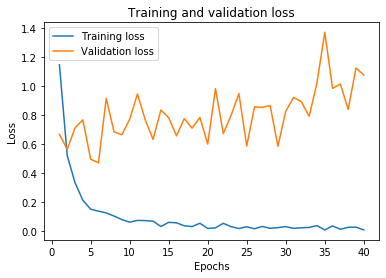

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


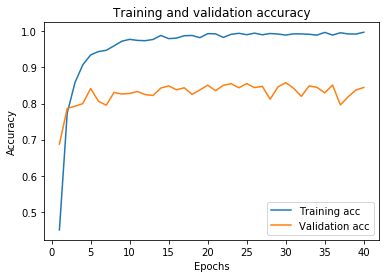

In [9]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [10]:
## Loading Best Weights from the Gang
model.load_weights(filepath)
from keras.preprocessing.image import ImageDataGenerator
datagentrain = ImageDataGenerator(featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06,
                rotation_range=5, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None,
                shear_range=0, zoom_range=0.0,
                channel_shift_range=0.0, fill_mode='nearest',
                cval=0.0, horizontal_flip=True, vertical_flip=True,
                rescale=None, preprocessing_function=None,
                data_format=None, validation_split=0.0)




In [11]:
datagentrain.fit(X_train)

In [12]:
history = model.fit_generator(datagentrain.flow(X_train, y_trainHot, batch_size=32),
                    steps_per_epoch=6,
                    epochs=40,
                    workers=4,
                    use_multiprocessing=False,validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,)



Epoch 1/40
6/6 [==============================] - ETA: 1s - loss: 7.5398e-04 - acc: 1.000 - ETA: 1s - loss: 5.6082e-04 - acc: 1.000 - ETA: 0s - loss: 0.0305 - acc: 0.9896    - ETA: 0s - loss: 0.0469 - acc: 0.976 - ETA: 0s - loss: 0.0413 - acc: 0.981 - 7s 1s/step - loss: 0.0346 - acc: 0.9844 - val_loss: 0.7017 - val_acc: 0.8548

Epoch 00001: val_acc did not improve from 0.85766
Epoch 2/40
6/6 [==============================] - ETA: 1s - loss: 0.0740 - acc: 0.937 - ETA: 1s - loss: 0.0802 - acc: 0.953 - ETA: 0s - loss: 0.0627 - acc: 0.958 - ETA: 0s - loss: 0.0531 - acc: 0.968 - ETA: 0s - loss: 0.0571 - acc: 0.962 - 7s 1s/step - loss: 0.0563 - acc: 0.9635 - val_loss: 0.9062 - val_acc: 0.8464

Epoch 00002: val_acc did not improve from 0.85766
Epoch 3/40
6/6 [==============================] - ETA: 1s - loss: 0.1830 - acc: 0.968 - ETA: 1s - loss: 0.1002 - acc: 0.984 - ETA: 0s - loss: 0.1255 - acc: 0.968 - ETA: 0s - loss: 0.1054 - acc: 0.968 - ETA: 0s - loss: 0.0847 - acc: 0.975 - 7s 1s/step -

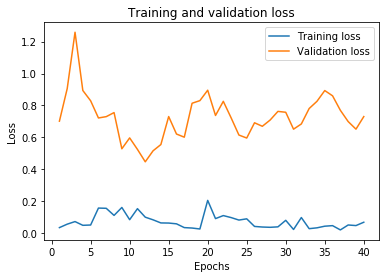

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

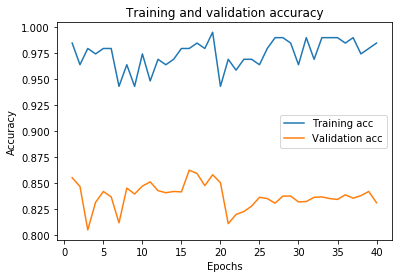

In [14]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
print(acc)

[0.984375, 0.9635416666666666, 0.9791666666666666, 0.9739583333333334, 0.9791666666666666, 0.9791666666666666, 0.9427083333333334, 0.9635416666666666, 0.9427083333333334, 0.9739583333333334, 0.9479166666666666, 0.96875, 0.9635416666666666, 0.96875, 0.9791666666666666, 0.9791666666666666, 0.984375, 0.9791666666666666, 0.9947916666666666, 0.9427083333333334, 0.96875, 0.9583333333333334, 0.96875, 0.96875, 0.9635416666666666, 0.9791666666666666, 0.9895833333333334, 0.9895833333333334, 0.984375, 0.9635416666666666, 0.9895833333333334, 0.96875, 0.9895833333333334, 0.9895833333333334, 0.9895833333333334, 0.984375, 0.9895833333333334, 0.9739583333333334, 0.9791666666666666, 0.984375]


In [25]:
print(val_acc)

[0.8548451947504419, 0.8464012866907921, 0.8045838357791586, 0.8311218336542112, 0.8415761960525804, 0.8363490149971947, 0.8114193808998887, 0.8447929232006434, 0.8391636509132232, 0.8468033774914299, 0.8508242863126677, 0.8423803778935207, 0.8403699234349689, 0.8415761959567145, 0.8411741050841773, 0.8620828305519773, 0.8588661034758138, 0.8472054681722352, 0.8576598311458, 0.8500201047353587, 0.810615198891183, 0.8194611981589007, 0.8222758341707951, 0.8275030156096446, 0.8359469241965569, 0.83474065141118, 0.8303176518132709, 0.8371531965505372, 0.8371531966464032, 0.8315239244308824, 0.8319260152075537, 0.8359469237411937, 0.836349014613731, 0.834740651315314, 0.8339364695702397, 0.8383594690722829, 0.8351427420919854, 0.8375552873272085, 0.8415761962443122, 0.8307197425899421]
